In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import glob
import random
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

# Set random seeds for reproducibility


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


seed_everything()
warnings.filterwarnings('ignore')

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-09-13 09:24:51.325452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757755491.510853      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757755491.559941      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version 2.18.0


# Lightweight ViT Model Implementation

The following cells implement the core components of our lightweight Vision Transformer:


In [2]:
# -----------------------------
# Imports
# -----------------------------
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers as L, models
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [3]:
# -----------------------------
# Configurations
# -----------------------------
data_dir = "/kaggle/input/auggerd/Gerd_Aug"
image_size = 224  # Reduced input size for lightweight
patch_size = 8   # Larger patch size to reduce patch count
projection_dim = 64  # Lower embedding dimension
transformer_layers = 4  # Reduced layers
num_heads = 4    # Fewer attention heads
mlp_head_units = [128, 64]  # Simplified MLP head
batch_size = 32
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-5

# List all classes (folders) inside dataset
classes = sorted(os.listdir(data_dir))
print(f"Found {len(classes)} classes:\n")

# Count files per class
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):  # make sure it's a folder
        num_files = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        print(f"{cls:20s} -> {num_files} files")


Found 4 classes:

Gerd                 -> 1150 files
Gerd Normal          -> 1150 files
Polyp                -> 1150 files
Polyp Normal         -> 1150 files


In [4]:
import os
import pandas as pd

# -----------------------------
# Data: auto-detect classes
# -----------------------------
def get_class_names(data_dir):
    """Return sorted list of class folder names."""
    return sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

def create_dataframe(data_dir):
    """Create a dataframe with image paths, string labels, and integer labels."""
    categories = get_class_names(data_dir)
    data = []

    for label, category in enumerate(categories):
        path = os.path.join(data_dir, category)
        for img_name in os.listdir(path):
            if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                data.append({
                    'image_path': os.path.join(path, img_name),
                    'category': category,  # string label
                    'label': label          # integer label for StratifiedKFold
                })

    df = pd.DataFrame(data)
    return df, categories

def train_val_split(df, val_split=0.2):
    """Randomly shuffle and split dataframe into train/validation sets."""
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    val_size = int(len(df) * val_split)
    return df[val_size:], df[:val_size]


In [5]:
# -----------------------------
# Data Generators (no augmentation)
# -----------------------------
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

def create_data_generators(train_df, val_df):
    train_gen = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='category',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    val_gen = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',
        y_col='category',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen

In [6]:
# -----------------------------
# Patch layer
# -----------------------------
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# -----------------------------
# Patch Encoder layer
# -----------------------------
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units=projection_dim)
        self.position_embedding = L.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# -----------------------------
# MLP for Transformer
# -----------------------------
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation='gelu')(x)
        x = L.Dropout(dropout_rate)(x)
    return x

# -----------------------------
# Create Lightweight ViT Model
# -----------------------------
def create_lightweight_vit(n_classes):
    inputs = L.Input(shape=(image_size, image_size, 3))
    num_patches = (image_size // patch_size) ** 2

    # Patches + Encoding
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    x = encoded_patches
    for _ in range(transformer_layers):
        x1 = L.LayerNormalization(epsilon=1e-6)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim // num_heads,
            dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim, projection_dim], dropout_rate=0.1)
        x = L.Add()([x3, x2])

    # Classification head
    representation = L.LayerNormalization(epsilon=1e-6)(x)
    representation = L.GlobalAveragePooling1D()(representation)
    representation = L.Dropout(0.3)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    logits = L.Dense(n_classes, activation='softmax')(features)

    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [7]:
# -----------------------------
# Prepare Data
# -----------------------------
df, class_names = create_dataframe(data_dir)
train_df, val_df = train_val_split(df)
train_generator, validation_generator = create_data_generators(train_df, val_df)

# -----------------------------
# Create Model
# -----------------------------
n_classes = len(class_names)
model = create_lightweight_vit(n_classes)
model.summary()

Found 3680 validated image filenames belonging to 4 classes.
Found 920 validated image filenames belonging to 4 classes.


I0000 00:00:1757755518.417439      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 192) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 784, 64)   │     62,528 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 784, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 784, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 784, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 784, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 784, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 784, 64)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 784, 64)   │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 784, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 784, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 784, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 784, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 784, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 784, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 784, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 784, 64)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 784, 64)   │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 180,356 (704.52 KB)

 Trainable params: 180,356 (704.52 KB)

 Non-trainable params: 0 (0.00 B)

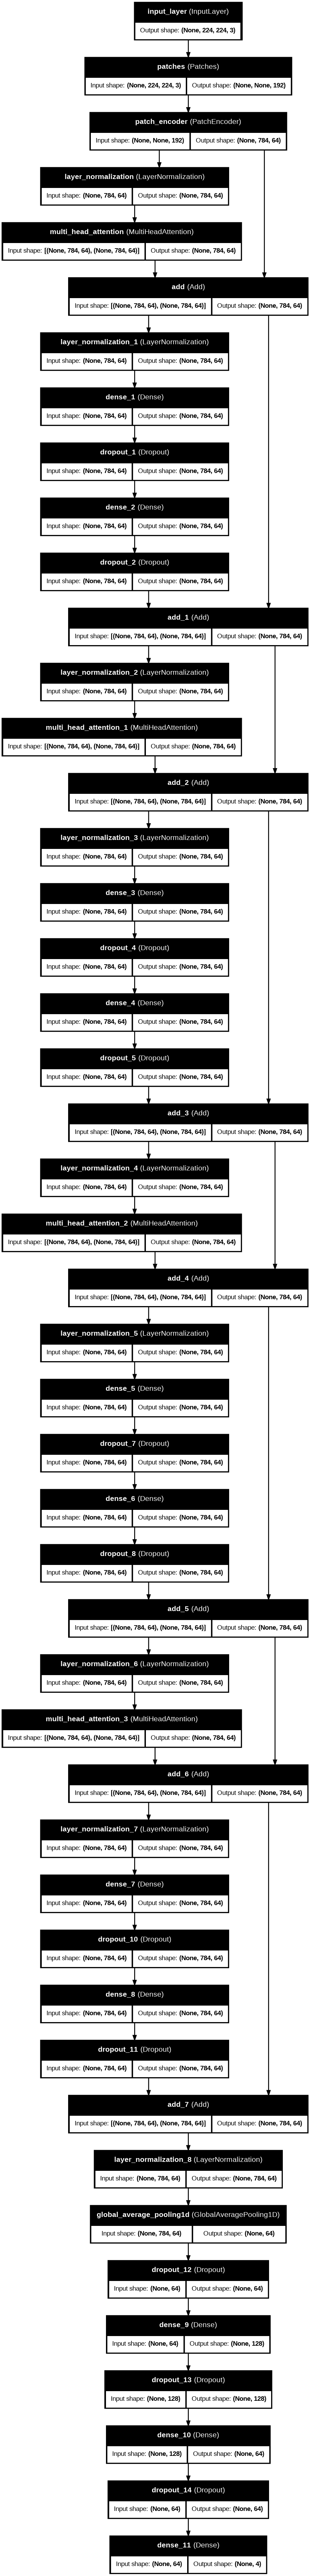

In [8]:
from tensorflow.keras.utils import plot_model

# Save the model diagram as PNG
plot_model(
    model, 
    to_file="vit_model.png", 
    show_shapes=True, 
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)


✓ Architecture diagram saved to: /kaggle/working/plots/gerd_model3_vit_architecture.png


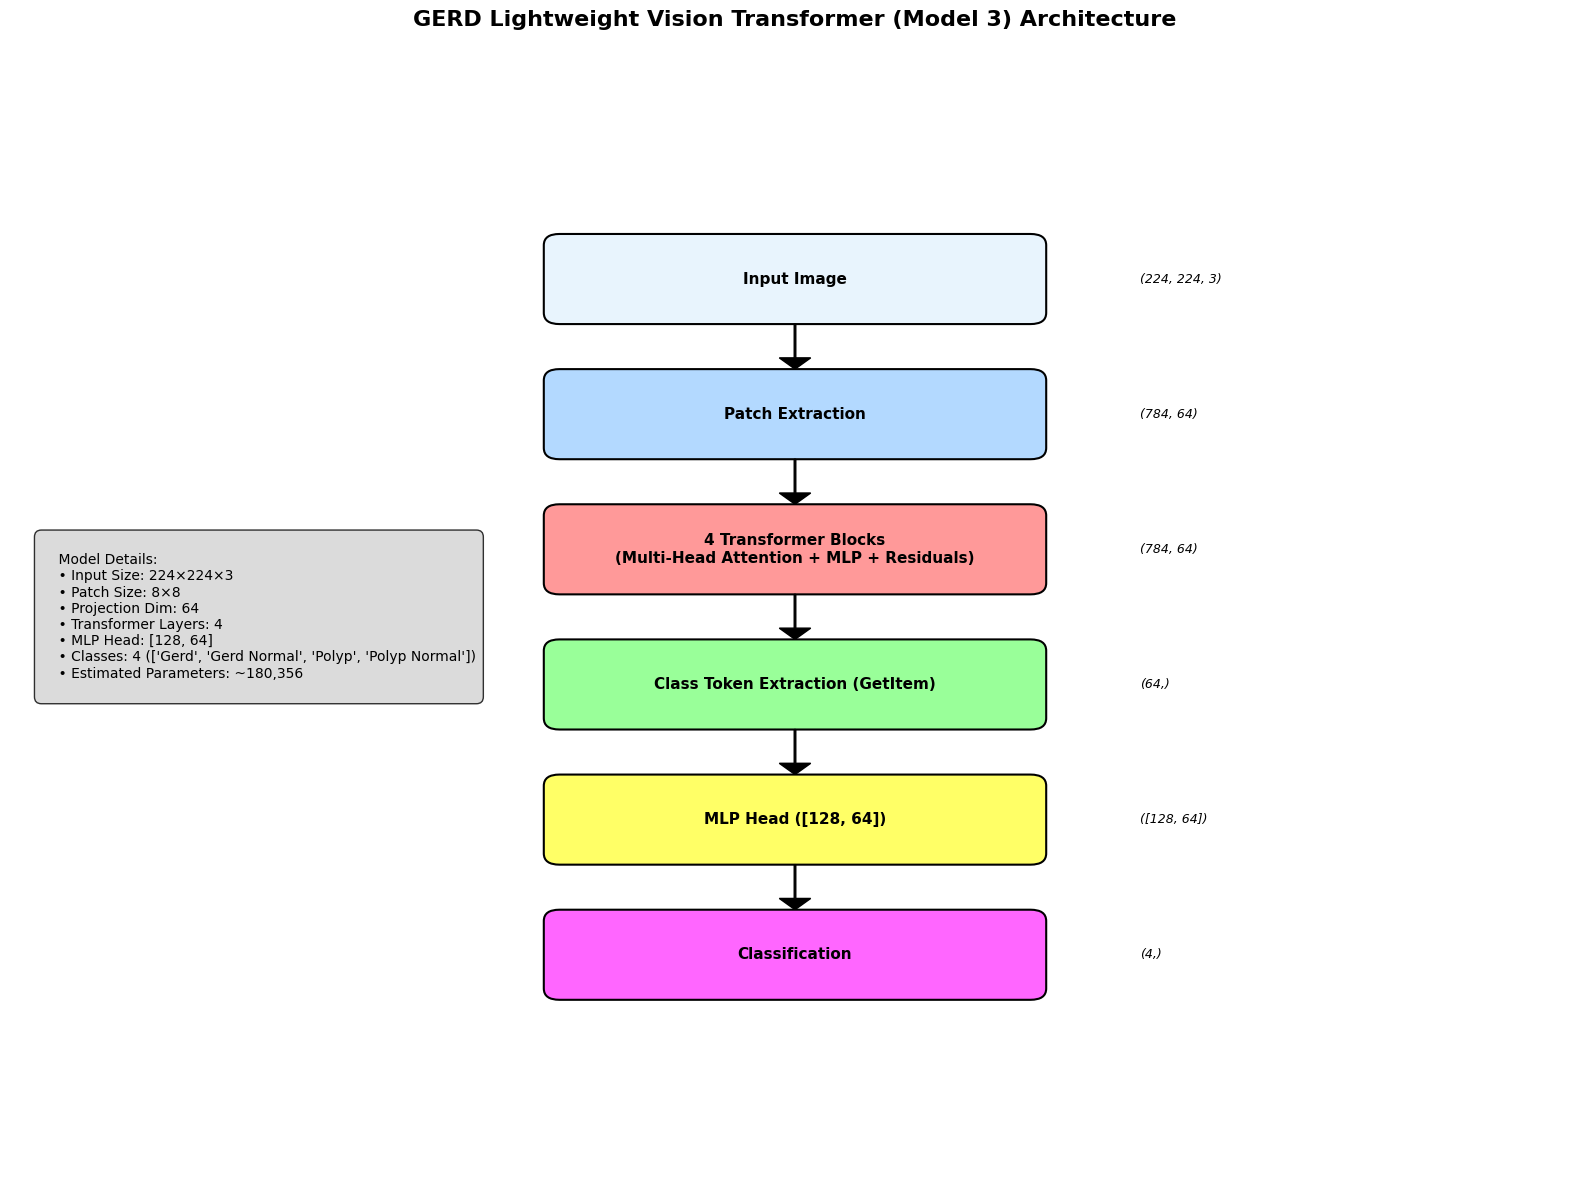

In [9]:
def visualize_model_vit_architecture(model, image_size, patch_size, projection_dim,
                                     transformer_layers, mlp_head_units, n_classes,
                                     class_names=None, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

    components = [
        {"name": "Input Image", "type": "input", "shape": f"({image_size}, {image_size}, 3)", "color": "#E8F4FD"},
        {"name": "Patch Extraction", "type": "embedding", "shape": f"({(image_size//patch_size)**2}, 192)", "color": "#B3D9FF"},
        {"name": f"{transformer_layers} Transformer Blocks\n(Multi-Head Attention + MLP + Residuals)", 
         "type": "transformer", "shape": f"({(image_size//patch_size)**2}, {projection_dim})", "color": "#FF9999"},
        {"name": "Global Average Pooling", "type": "pooling", "shape": f"({projection_dim},)", "color": "#99FF99"},
        {"name": f"MLP Head ({mlp_head_units})", "type": "mlp", "shape": f"({mlp_head_units})", "color": "#FFFF66"},
        {"name": "Classification", "type": "output", "shape": f"({n_classes},)", "color": "#FF66FF"}
    ]

    y_positions = np.linspace(0.8, 0.2, len(components))
    box_height = 0.06
    box_width = 0.3

    for i, comp in enumerate(components):
        y_pos = y_positions[i]

        box = FancyBboxPatch(
            (0.35, y_pos - box_height/2), box_width, box_height,
            boxstyle="round,pad=0.01",
            facecolor=comp["color"],
            edgecolor='black',
            linewidth=1.5
        )
        ax.add_patch(box)
        ax.text(0.5, y_pos, comp["name"], ha='center', va='center', fontsize=11, fontweight='bold')
        ax.text(0.72, y_pos, comp["shape"], ha='left', va='center', fontsize=9, style='italic')

        if i < len(components) - 1:
            ax.arrow(0.5, y_pos - box_height/2 - 0.01, 0, -0.03,
                     head_width=0.02, head_length=0.01, fc='black', ec='black')

    ax.set_title('GERD Lightweight Vision Transformer Architecture', fontsize=16, fontweight='bold', pad=20)

    details_text = f"""
    Model Details:
    • Input Size: {image_size}×{image_size}×3
    • Patch Size: {patch_size}×{patch_size}
    • Projection Dim: {projection_dim}
    • Transformer Layers: {transformer_layers}
    • MLP Head: {mlp_head_units}
    • Classes: {n_classes} ({class_names})
    • Estimated Parameters: ~{model.count_params():,}
    """
    ax.text(0.02, 0.5, details_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='center', bbox=dict(boxstyle="round,pad=0.5",
                                                 facecolor='lightgray', alpha=0.8))

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Architecture diagram saved to: {save_path}")

    plt.show()

# -----------------------------
# Usage
visualize_model_vit_architecture(
    model=model,
    image_size=224,
    patch_size=16,
    projection_dim=64,
    transformer_layers=4,
    mlp_head_units=[128, 64],
    n_classes=4,
    class_names=class_names,
    save_path=os.path.join(PLOTS_DIR, 'gerd_vit_model_architecture.png')
)

In [10]:
# -----------------------------
# Optimizer & Learning Rate Schedule
# -----------------------------
decay_steps = len(train_generator) * num_epochs

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    alpha=1e-4
)

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

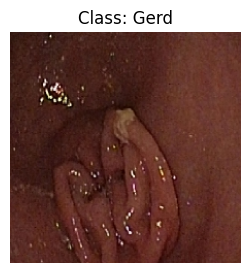

Image size: 224x224
Patch size: 8x8
Patches per image: 784
Elements per patch: 192


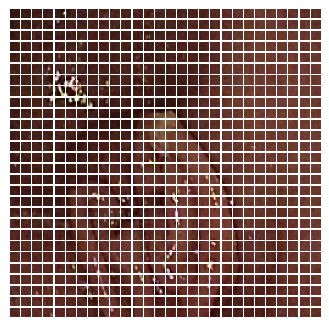

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# -----------------------------
# Sample Image Patches Visualization
# -----------------------------
def visualize_image_patches(generator, class_names, image_size, patch_size, n_samples=1):
    """
    Visualize sample images and their patches from a generator.
    
    Args:
        generator: Keras data generator
        class_names: list of class names
        image_size: target image size (int)
        patch_size: size of each patch (int)
        n_samples: number of images to visualize
    """
    x_batch, y_batch = next(iter(generator))  # Get one batch
    
    for idx in range(min(n_samples, len(x_batch))):
        image = x_batch[idx]  # Float32 in [0,1]
        label_idx = np.argmax(y_batch[idx])
        
        # Display original image (convert to uint8)
        plt.figure(figsize=(3,3))
        plt.imshow((image * 255).astype('uint8'))  # Scale to 0-255
        plt.title(f"Class: {class_names[label_idx]}")
        plt.axis('off')
        plt.show()
        
        # Resize and extract patches
        resized_image = tf.image.resize(tf.expand_dims(image, axis=0), (image_size, image_size))
        patches_layer = Patches(patch_size)
        patches = patches_layer(resized_image)
        
        print(f"Image size: {image_size}x{image_size}")
        print(f"Patch size: {patch_size}x{patch_size}")
        print(f"Patches per image: {patches.shape[1]}")
        print(f"Elements per patch: {patches.shape[-1]}")
        
        # Plot patches
        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4,4))
        for i, patch in enumerate(patches[0]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
            # Ensure proper scaling for visualization
            patch_img = tf.clip_by_value(patch_img, 0, 1)
            plt.imshow((patch_img.numpy() * 255).astype('uint8'))
            plt.axis('off')
        plt.tight_layout()
        plt.show()


# Example usage
visualize_image_patches(
    generator=train_generator,
    class_names=class_names,
    image_size=image_size,
    patch_size=patch_size,
    n_samples=1
)

In [14]:
import os
import gc
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras import optimizers, losses

# ----------------------------
# K-Fold Configuration
# ----------------------------
KFOLD_CONFIG = {
    'n_splits': 5,  
    'epochs': 50,   
    'batch_size': 16,  
    'image_size': (224, 224),  
    'use_subset': False, 
    'subset_ratio': 1.0,  
    'patience': 20,  
    'monitor': 'val_accuracy'
}

# Initialize storage
fold_histories = []
fold_models = []
fold_predictions = []
fold_true_labels = []
fold_metrics = []
training_times = []

# Prepare dataset
all_file_paths = []
all_labels_encoded = []
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    files = [os.path.join(class_path, f) for f in os.listdir(class_path)
             if f.endswith(('.jpg', '.png', '.jpeg'))]
    all_file_paths.extend(files)
    all_labels_encoded.extend([class_idx] * len(files))

all_file_paths = np.array(all_file_paths)
all_labels_encoded = np.array(all_labels_encoded)

# Subset for faster testing
if KFOLD_CONFIG['use_subset']:
    from sklearn.model_selection import train_test_split
    all_file_paths, _, all_labels_encoded, _ = train_test_split(
        all_file_paths, all_labels_encoded,
        train_size=KFOLD_CONFIG['subset_ratio'],
        stratify=all_labels_encoded,
        random_state=42
    )

# Stratified K-Fold
skfold = StratifiedKFold(n_splits=KFOLD_CONFIG['n_splits'], shuffle=True, random_state=42)

# Preprocessing
def preprocess_images(file_paths, labels, image_size, n_classes):
    images = []
    for fp in file_paths:
        try:
            img = tf.keras.preprocessing.image.load_img(fp, target_size=image_size)
            arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(arr)
        except:
            images.append(np.zeros((*image_size, 3)))
    return np.array(images), tf.keras.utils.to_categorical(labels, n_classes)

n_classes = len(class_names)
best_fold_model = None
best_val_acc = 0.0

# ----------------------------
# K-Fold Training
# ----------------------------
for fold_num, (train_idx, val_idx) in enumerate(skfold.split(all_file_paths, all_labels_encoded), 1):
    print(f"\n{'='*20} FOLD {fold_num}/{KFOLD_CONFIG['n_splits']} {'='*20}")
    fold_start = time.time()

    # Clear memory
    tf.keras.backend.clear_session()
    gc.collect()

    # Split data
    train_paths, val_paths = all_file_paths[train_idx], all_file_paths[val_idx]
    train_labels, val_labels = all_labels_encoded[train_idx], all_labels_encoded[val_idx]

    # Preprocess
    X_train, y_train = preprocess_images(train_paths, train_labels, KFOLD_CONFIG['image_size'], n_classes)
    X_val, y_val = preprocess_images(val_paths, val_labels, KFOLD_CONFIG['image_size'], n_classes)

    # Create new model instance per fold
    fold_model = create_lightweight_vit(n_classes)

    fold_model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss=losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor=KFOLD_CONFIG['monitor'],
            patience=KFOLD_CONFIG['patience'],
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Train
    history = fold_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=KFOLD_CONFIG['epochs'],
        batch_size=KFOLD_CONFIG['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    # Predict & metrics
    val_pred_probs = fold_model.predict(X_val, verbose=0)   # shape: (num_samples, n_classes)
    val_pred_classes = np.argmax(val_pred_probs, axis=1)    # for accuracy metrics
    
    # Store probabilities for ROC and discrete classes for metrics
    fold_predictions.append(val_pred_probs) 
    fold_true_labels.append(val_true_classes) 

    val_true_classes = np.argmax(y_val, axis=1)
    val_acc = accuracy_score(val_true_classes, val_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_true_classes, val_pred_classes, average='weighted'
    )


    fold_end = time.time()
    fold_time = fold_end - fold_start
    training_times.append(fold_time)

    fold_histories.append(history.history)
    fold_models.append(fold_model)
    fold_metrics.append({
        'accuracy': val_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': fold_time
    })

    print(f"\nFold {fold_num} Results: Acc: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Time: {fold_time:.1f}s")

    # Track best fold
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_fold_model = fold_model

# ----------------------------
# Overall Metrics
# ----------------------------
overall_accuracy = np.mean([m['accuracy'] for m in fold_metrics])
overall_precision = np.mean([m['precision'] for m in fold_metrics])
overall_recall = np.mean([m['recall'] for m in fold_metrics])
overall_f1 = np.mean([m['f1_score'] for m in fold_metrics])

print(f"\n{'='*70}")
print("K-FOLD CROSS VALIDATION COMPLETED")
print(f"Average Fold Time: {np.mean(training_times):.1f}s")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")
print(f"Best Fold Validation Accuracy: {best_val_acc:.4f}")
print(f"{'='*70}")



==================== FOLD 1/5 ====================
Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2625 - loss: 1.4372

2025-09-13 09:52:08.269765: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


230/230 ━━━━━━━━━━━━━━━━━━━━ 44s 105ms/step - accuracy: 0.2627 - loss: 1.4370 - val_accuracy: 0.4315 - val_loss: 1.2374 - learning_rate: 1.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.4168 - loss: 1.2387 - val_accuracy: 0.5315 - val_loss: 1.1084 - learning_rate: 1.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.4940 - loss: 1.0923 - val_accuracy: 0.5739 - val_loss: 1.0256 - learning_rate: 1.0000e-04
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.5346 - loss: 1.0554 - val_accuracy: 0.5750 - val_loss: 1.0230 - learning_rate: 1.0000e-04
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.5580 - loss: 1.0240 - val_accuracy: 0.6033 - val_loss: 1.0031 - learning_rate: 1.0000e-04
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.5561 - loss: 1.0111 - val_accuracy: 0.5870 - val_loss: 0.9929 - learning_rate: 1.0000e-04
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accura

2025-09-13 10:09:28.053313: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



Fold 1 Results: Acc: 0.9054, Precision: 0.9097, Recall: 0.9054, F1: 0.9056, Time: 1111.7s

==================== FOLD 2/5 ====================
Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2727 - loss: 1.4248

2025-09-13 10:10:39.695263: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


230/230 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - accuracy: 0.2729 - loss: 1.4246 - val_accuracy: 0.4500 - val_loss: 1.2398 - learning_rate: 1.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.4153 - loss: 1.2582 - val_accuracy: 0.5891 - val_loss: 1.0240 - learning_rate: 1.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5074 - loss: 1.1001 - val_accuracy: 0.6098 - val_loss: 0.9697 - learning_rate: 1.0000e-04
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5499 - loss: 1.0443 - val_accuracy: 0.6261 - val_loss: 0.9609 - learning_rate: 1.0000e-04
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5581 - loss: 1.0270 - val_accuracy: 0.5989 - val_loss: 0.9474 - learning_rate: 1.0000e-04
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5708 - loss: 1.0220 - val_accuracy: 0.6207 - val_loss: 0.9257 - learning_rate: 1.0000e-04
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accura

2025-09-13 10:27:47.820082: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



Fold 2 Results: Acc: 0.9337, Precision: 0.9344, Recall: 0.9337, F1: 0.9337, Time: 1099.6s

==================== FOLD 3/5 ====================
Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2678 - loss: 1.4181

2025-09-13 10:29:09.361177: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


230/230 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - accuracy: 0.2680 - loss: 1.4180 - val_accuracy: 0.4478 - val_loss: 1.2618 - learning_rate: 1.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.3940 - loss: 1.2761 - val_accuracy: 0.5380 - val_loss: 1.0955 - learning_rate: 1.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5064 - loss: 1.1061 - val_accuracy: 0.5891 - val_loss: 1.0395 - learning_rate: 1.0000e-04
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5169 - loss: 1.0549 - val_accuracy: 0.6217 - val_loss: 0.9681 - learning_rate: 1.0000e-04
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5447 - loss: 1.0272 - val_accuracy: 0.6500 - val_loss: 0.9290 - learning_rate: 1.0000e-04
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5617 - loss: 1.0177 - val_accuracy: 0.6598 - val_loss: 0.9287 - learning_rate: 1.0000e-04
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accura

2025-09-13 10:46:18.631644: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



Fold 3 Results: Acc: 0.9435, Precision: 0.9443, Recall: 0.9435, F1: 0.9433, Time: 1110.2s

==================== FOLD 4/5 ====================
Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2782 - loss: 1.4647

2025-09-13 10:47:39.455846: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


230/230 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - accuracy: 0.2782 - loss: 1.4644 - val_accuracy: 0.4489 - val_loss: 1.2759 - learning_rate: 1.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.3835 - loss: 1.3139 - val_accuracy: 0.5185 - val_loss: 1.1266 - learning_rate: 1.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.4683 - loss: 1.1253 - val_accuracy: 0.5402 - val_loss: 1.1157 - learning_rate: 1.0000e-04
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5098 - loss: 1.0759 - val_accuracy: 0.6022 - val_loss: 0.9933 - learning_rate: 1.0000e-04
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.5470 - loss: 1.0343 - val_accuracy: 0.6098 - val_loss: 1.0058 - learning_rate: 1.0000e-04
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5638 - loss: 1.0234 - val_accuracy: 0.5641 - val_loss: 1.1173 - learning_rate: 1.0000e-04
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accura

2025-09-13 11:04:46.514528: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



Fold 4 Results: Acc: 0.9533, Precision: 0.9537, Recall: 0.9533, F1: 0.9533, Time: 1108.8s

==================== FOLD 5/5 ====================
Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2627 - loss: 1.4384

2025-09-13 11:06:01.414392: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


230/230 ━━━━━━━━━━━━━━━━━━━━ 43s 103ms/step - accuracy: 0.2628 - loss: 1.4382 - val_accuracy: 0.4304 - val_loss: 1.2292 - learning_rate: 1.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.4369 - loss: 1.2360 - val_accuracy: 0.6043 - val_loss: 0.9926 - learning_rate: 1.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.4984 - loss: 1.1102 - val_accuracy: 0.6098 - val_loss: 0.9526 - learning_rate: 1.0000e-04
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5443 - loss: 1.0516 - val_accuracy: 0.5935 - val_loss: 0.9462 - learning_rate: 1.0000e-04
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5437 - loss: 1.0362 - val_accuracy: 0.5826 - val_loss: 0.9562 - learning_rate: 1.0000e-04
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5592 - loss: 1.0292 - val_accuracy: 0.6076 - val_loss: 0.9339 - learning_rate: 1.0000e-04
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accura

2025-09-13 11:23:00.497101: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



Fold 5 Results: Acc: 0.9543, Precision: 0.9548, Recall: 0.9543, F1: 0.9543, Time: 1093.0s

K-FOLD CROSS VALIDATION COMPLETED
Average Fold Time: 1104.7s
Overall Accuracy: 0.9380
Overall Precision: 0.9394
Overall Recall: 0.9380
Overall F1-Score: 0.9381
Best Fold Validation Accuracy: 0.9543


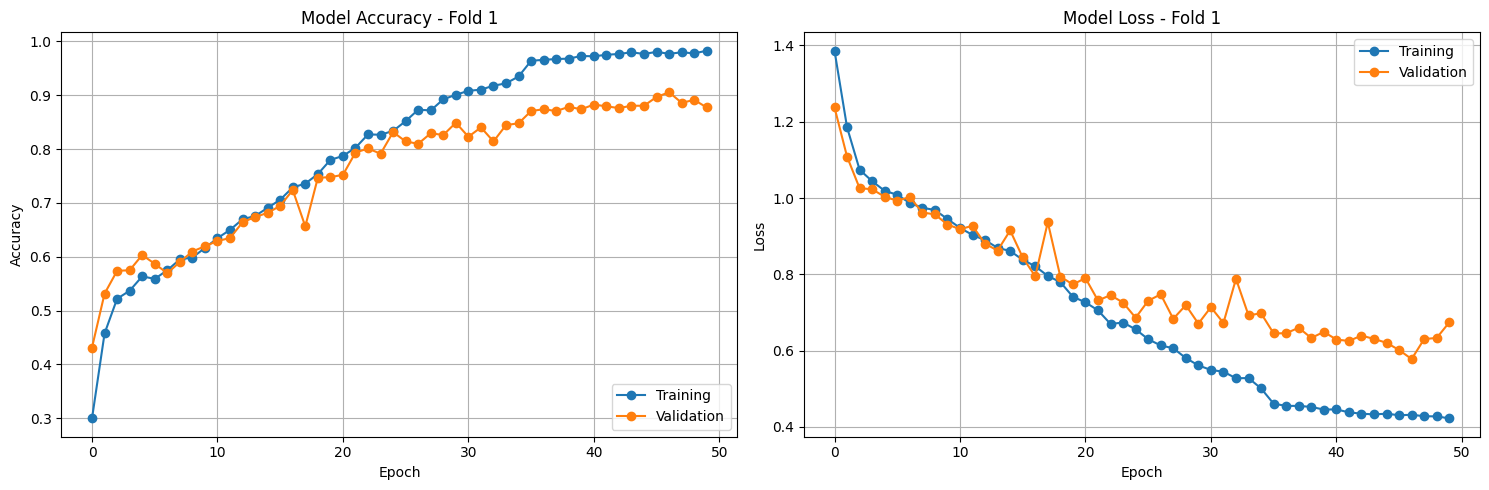

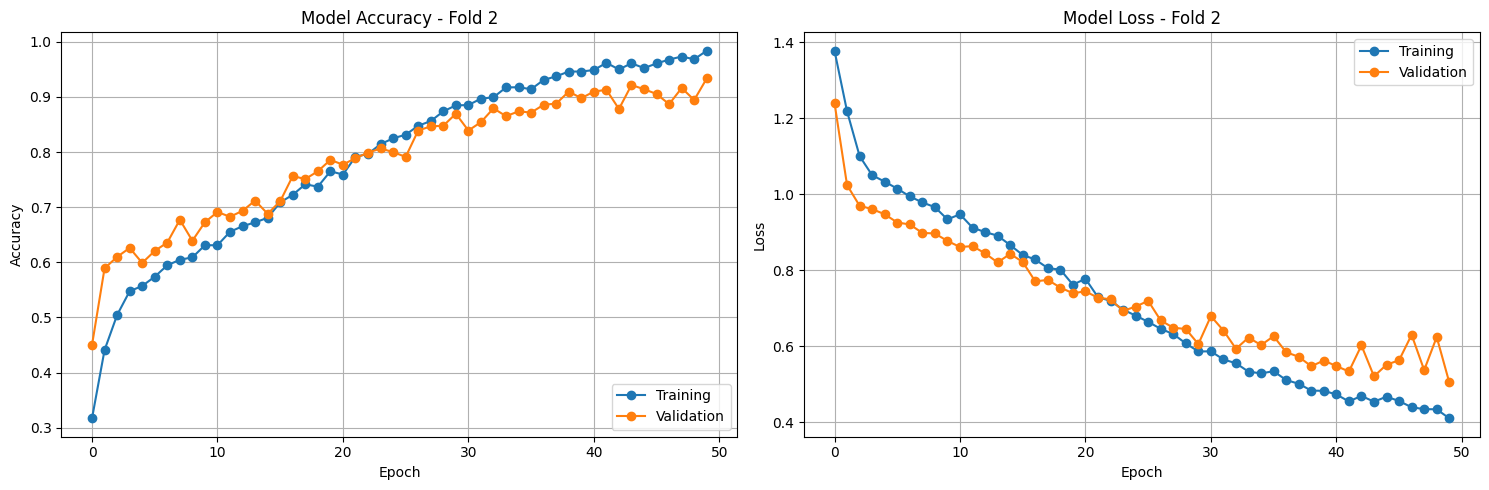

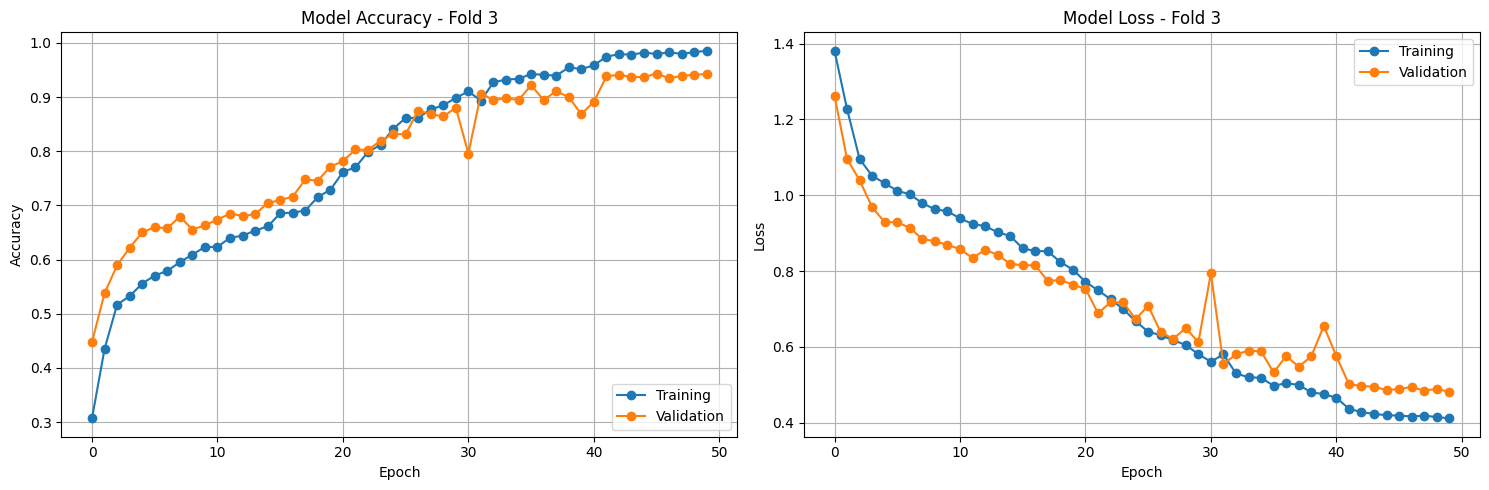

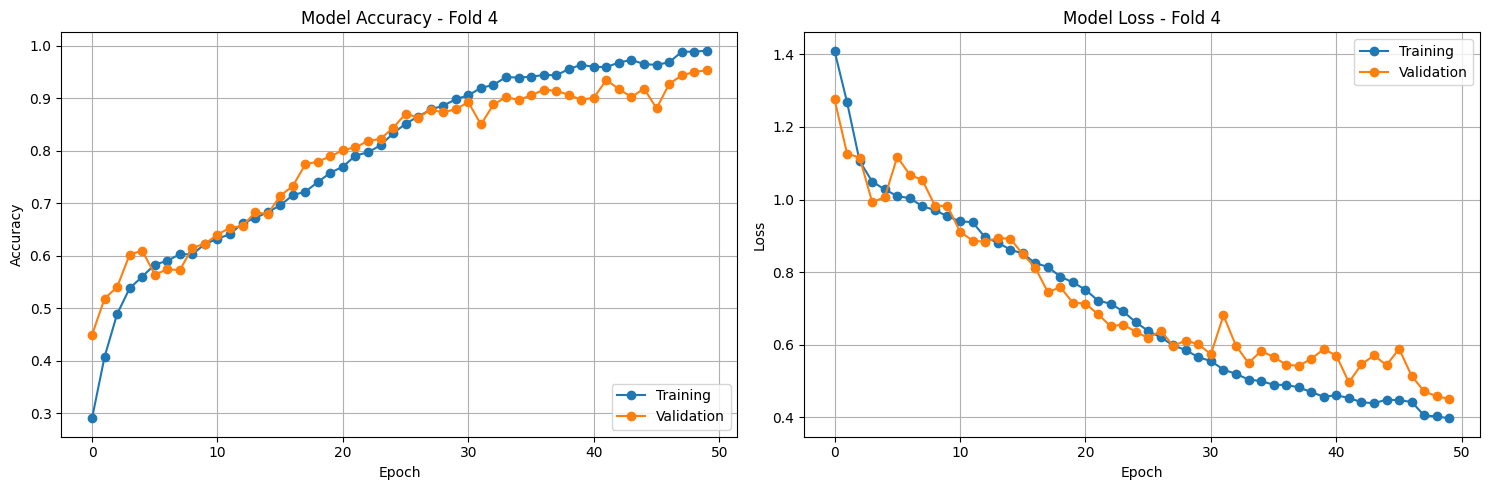

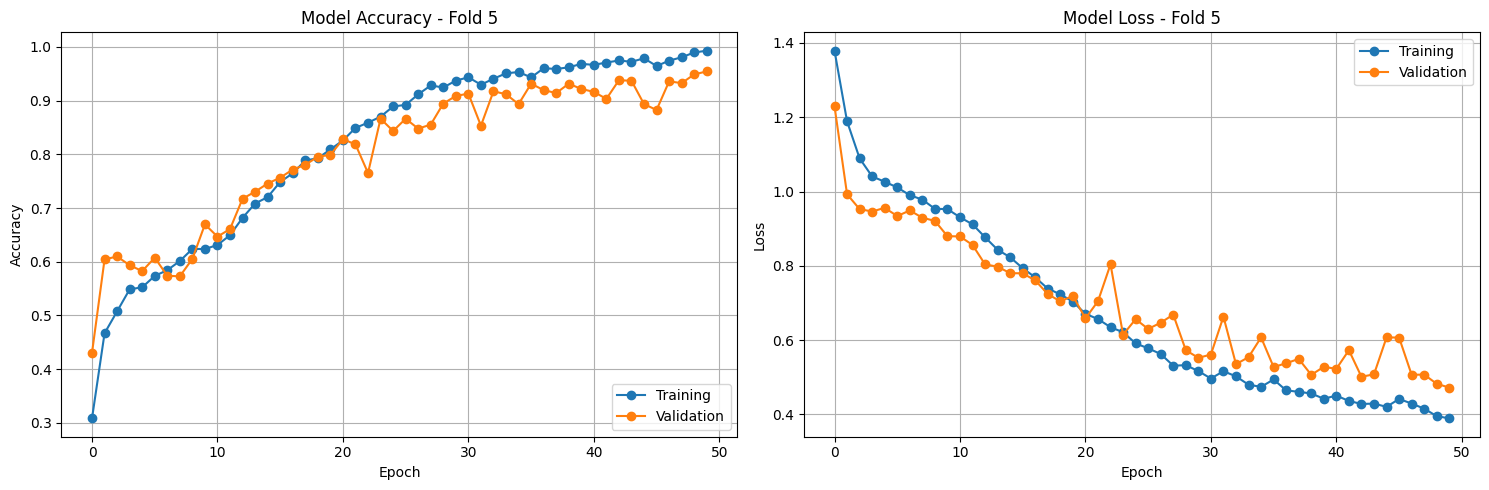

 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step 

2025-09-13 11:23:21.286685: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step

Best Fold Validation Accuracy: 0.9989
✓ Best fold model saved as lightweight_vit_best_fold.h5


In [15]:
import matplotlib.pyplot as plt

# -----------------------------
# Plot training history for a fold
# -----------------------------
def plot_training_history(history, fold_num=None):
    fig, gs = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1 = gs[0]
    ax1.plot(history['accuracy'], label='Training', marker='o')
    ax1.plot(history['val_accuracy'], label='Validation', marker='o')
    ax1.set_title(f'Model Accuracy' + (f' - Fold {fold_num}' if fold_num else ''))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)
    ax1.legend(loc='lower right')

    # Loss
    ax2 = gs[1]
    ax2.plot(history['loss'], label='Training', marker='o')
    ax2.plot(history['val_loss'], label='Validation', marker='o')
    ax2.set_title(f'Model Loss' + (f' - Fold {fold_num}' if fold_num else ''))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


# -----------------------------
# Plot histories for all folds
# -----------------------------
for i, hist in enumerate(fold_histories, 1):
    plot_training_history(hist, fold_num=i)


# -----------------------------
# Evaluate best fold model
# -----------------------------
best_val_idx = np.argmax([m['accuracy'] for m in fold_metrics])
best_model = fold_models[best_val_idx]
X_val_best, y_val_best = preprocess_images(
    all_file_paths[skfold.split(all_file_paths, all_labels_encoded).__next__()[1]],  # optional, or use saved val split
    all_labels_encoded[skfold.split(all_file_paths, all_labels_encoded).__next__()[1]],
    KFOLD_CONFIG['image_size'],
    n_classes
)

val_pred = best_model.predict(X_val_best)
val_acc = accuracy_score(np.argmax(y_val_best, axis=1), np.argmax(val_pred, axis=1))
print(f"\nBest Fold Validation Accuracy: {val_acc:.4f}")

# -----------------------------
# Save the best model
# -----------------------------
best_model.save('lightweight_vit_best_fold.h5')
print("✓ Best fold model saved as lightweight_vit_best_fold.h5")


In [ ]:
# # -----------------------------
# # Train the Model
# # -----------------------------
# history = model.fit(
#     train_generator,
#     epochs=num_epochs,
#     validation_data=validation_generator,
#     callbacks=callbacks
# )

# Model Evaluation Metrics

Below are detailed evaluation metrics including classification report, ROC-AUC curves, and confusion matrix:


Combining results from 5 folds...
Total combined samples: 4600


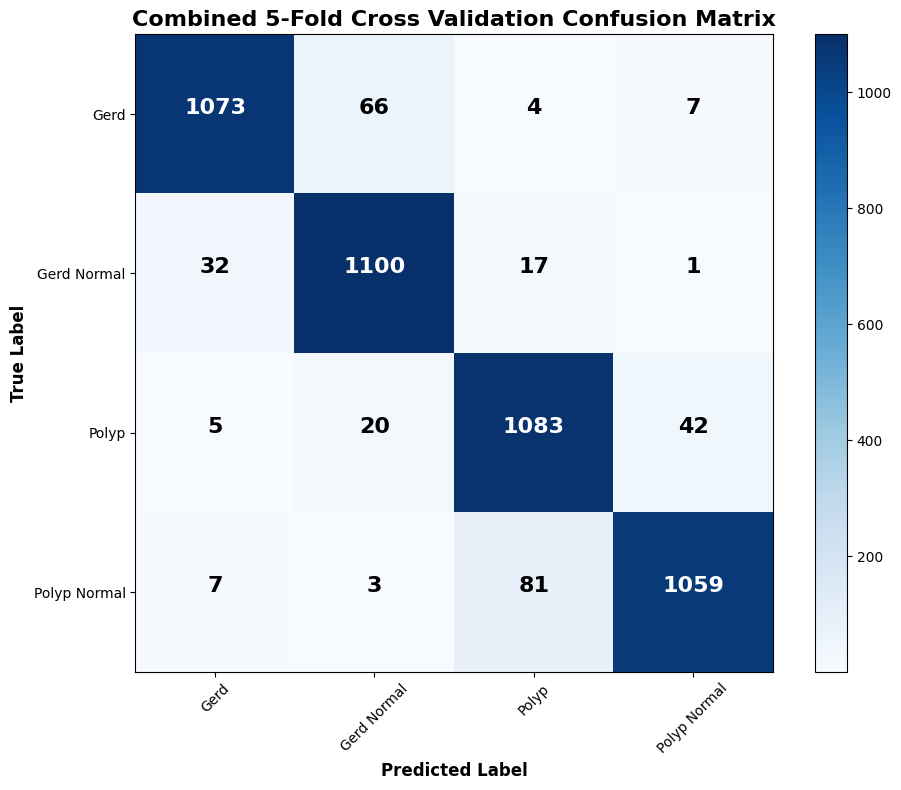

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import os

# Ensure plots directory exists
os.makedirs(PLOTS_DIR, exist_ok=True)

# -----------------------------
# Combine predictions and true labels across all folds
# -----------------------------
if 'fold_predictions' not in locals() or 'fold_true_labels' not in locals():
    print("⚠ Warning: No K-fold results found. Using dummy data.")
    all_combined_predictions = [0, 1, 2, 0, 1, 2]
    all_combined_true_labels = [0, 1, 2, 1, 0, 2]
else:
    all_combined_predictions = []
    all_combined_true_labels = []
    print(f"Combining results from {len(fold_predictions)} folds...")

    for fold_idx, (fold_pred, fold_true) in enumerate(zip(fold_predictions, fold_true_labels)):
        # Convert predictions to class indices if necessary
        if len(fold_pred.shape) == 2 and fold_pred.shape[1] > 1:
            pred_classes = np.argmax(fold_pred, axis=1)
        else:
            pred_classes = fold_pred.flatten()

        # Convert true labels to class indices if necessary
        if len(fold_true.shape) == 2 and fold_true.shape[1] > 1:
            true_classes = np.argmax(fold_true, axis=1)
        else:
            true_classes = fold_true.flatten()

        all_combined_predictions.extend(pred_classes)
        all_combined_true_labels.extend(true_classes)

all_combined_predictions = np.array(all_combined_predictions)
all_combined_true_labels = np.array(all_combined_true_labels)

print(f"Total combined samples: {len(all_combined_predictions)}")

# -----------------------------
# Compute confusion matrix
# -----------------------------
num_classes = len(class_names) if 'class_names' in locals() else len(np.unique(all_combined_true_labels))
combined_cm = confusion_matrix(all_combined_true_labels, all_combined_predictions, labels=np.arange(num_classes))

# -----------------------------
# Plot function
# -----------------------------
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.tight_layout()

# Ensure class names exist
if 'class_names' not in locals():
    class_names = [f'Class_{i}' for i in range(num_classes)]

# Plot and save
actual_folds = len(fold_predictions) if 'fold_predictions' in locals() else 3
plot_confusion_matrix(combined_cm, class_names,
                      title=f'Combined {actual_folds}-Fold Cross Validation Confusion Matrix')

plt.savefig(os.path.join(PLOTS_DIR, 'combined_confusion_matrix.png'),
            dpi=300, bbox_inches='tight')
plt.show()


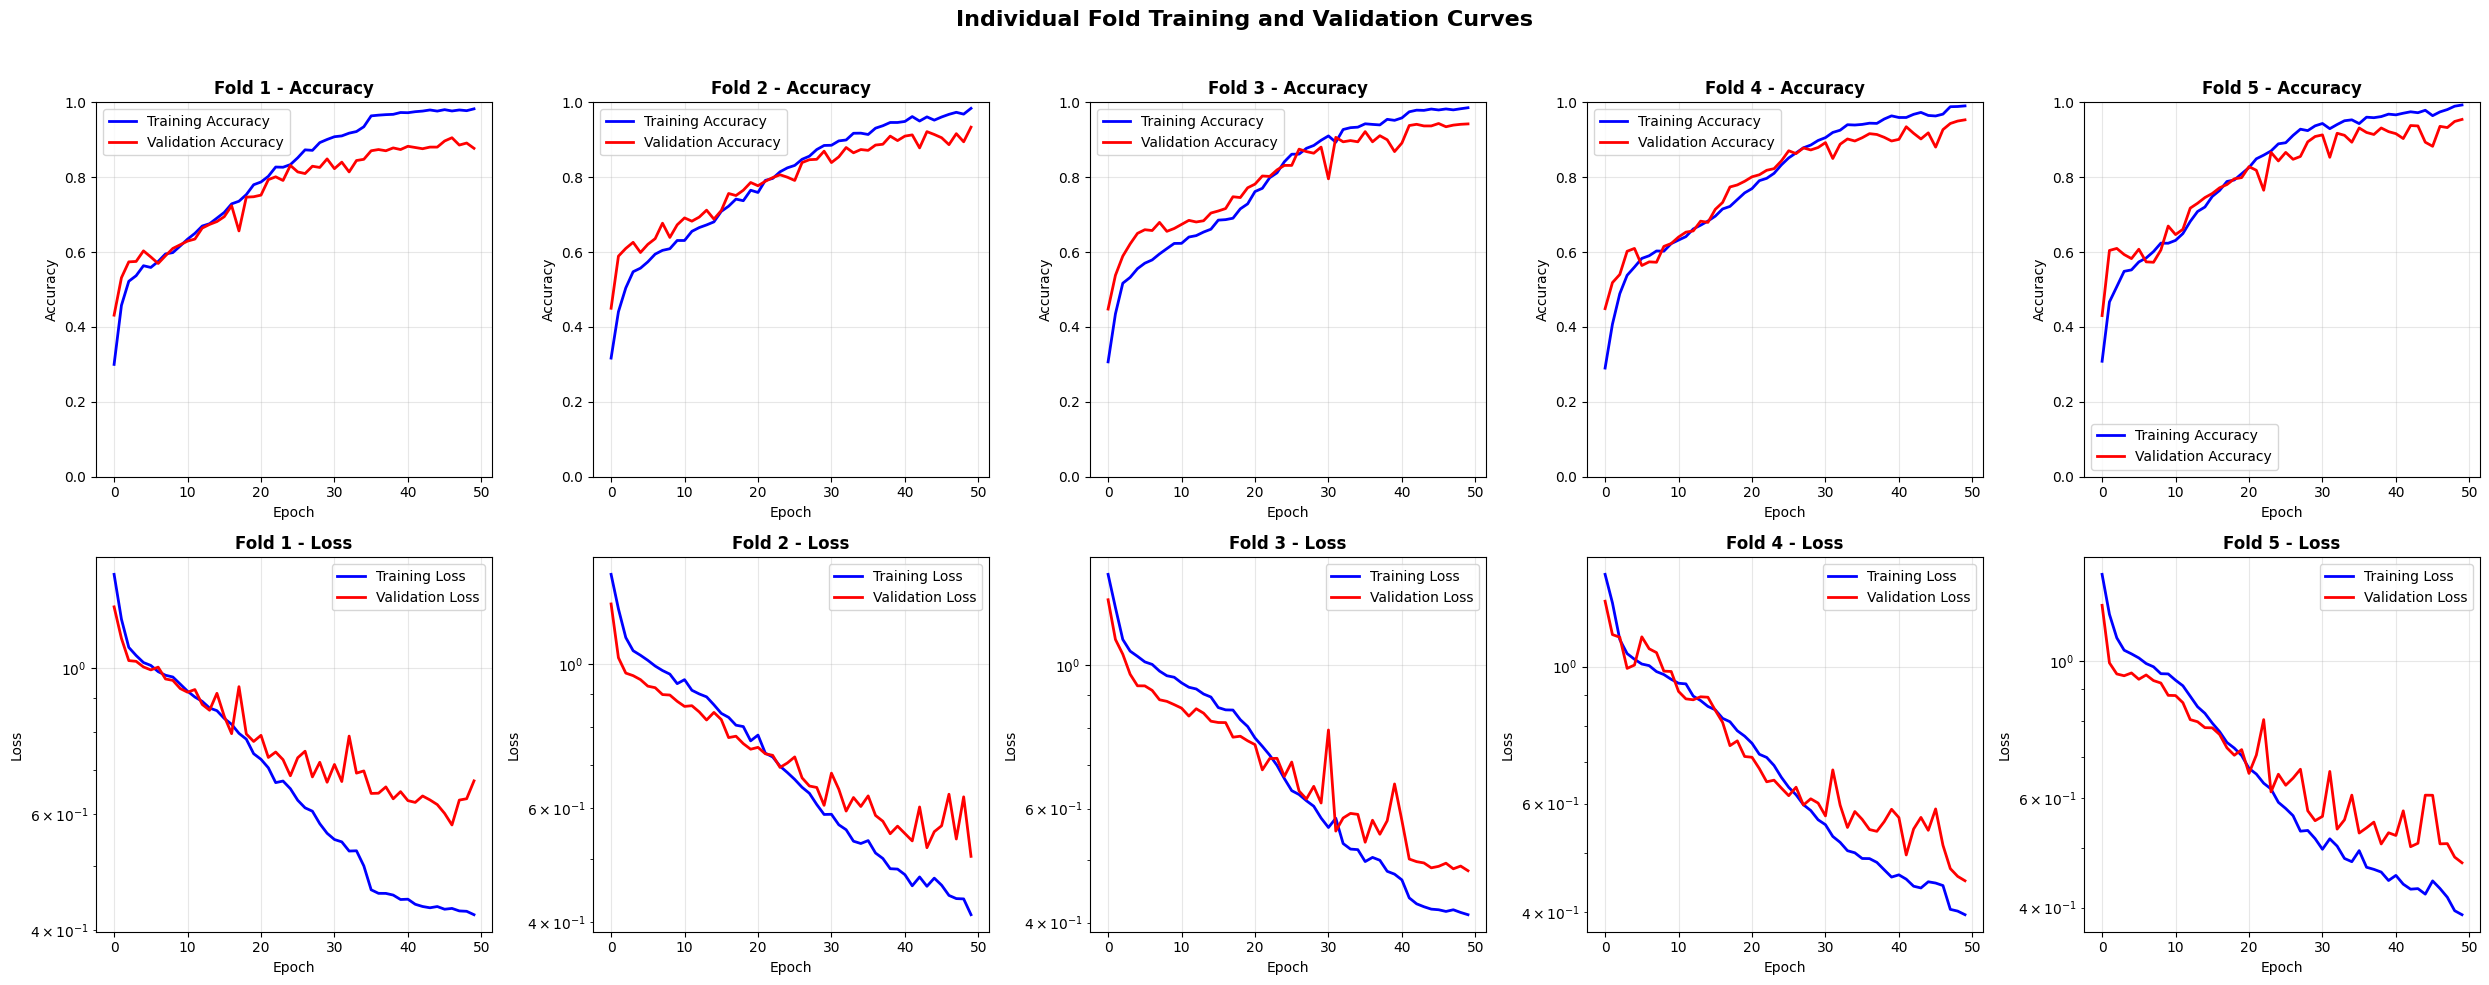

Individual Fold Performance Summary:
Fold   Train Acc    Val Acc      Train Loss   Val Loss    
----------------------------------------------------------------------
1      0.9826       0.8772       4.2227e-01   6.7389e-01  
2      0.9840       0.9337       4.1082e-01   5.0549e-01  
3      0.9856       0.9424       4.1141e-01   4.8108e-01  
4      0.9905       0.9533       3.9664e-01   4.5015e-01  
5      0.9929       0.9543       3.8961e-01   4.7249e-01  


In [17]:
import matplotlib.pyplot as plt
import os

# Create plots directory if it doesn't exist
os.makedirs(PLOTS_DIR, exist_ok=True)

n_folds = len(fold_histories)

# Create dynamic subplot grid: 2 rows (accuracy, loss) x n_folds
fig, axes = plt.subplots(2, n_folds, figsize=(5 * n_folds, 10))
fig.suptitle('Individual Fold Training and Validation Curves', fontsize=16, fontweight='bold')

for i, history in enumerate(fold_histories):
    # Accuracy subplot
    axes[0, i].plot(history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, i].plot(history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, i].set_title(f'Fold {i+1} - Accuracy', fontweight='bold')
    axes[0, i].set_xlabel('Epoch')
    axes[0, i].set_ylabel('Accuracy')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].set_ylim([0, 1])

    # Loss subplot
    axes[1, i].plot(history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[1, i].plot(history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[1, i].set_title(f'Fold {i+1} - Loss', fontweight='bold')
    axes[1, i].set_xlabel('Epoch')
    axes[1, i].set_ylabel('Loss')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].set_yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(PLOTS_DIR, 'individual_fold_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Print summary statistics for each fold
# -----------------------------
print("Individual Fold Performance Summary:")
print("="*70)
print(f"{'Fold':<6} {'Train Acc':<12} {'Val Acc':<12} {'Train Loss':<12} {'Val Loss':<12}")
print("-"*70)

for i, history in enumerate(fold_histories):
    final_train_acc = history['accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]

    print(f"{i+1:<6} {final_train_acc:<12.4f} {final_val_acc:<12.4f} {final_train_loss:<12.4e} {final_val_loss:<12.4e}")

print("="*70)

Creating overlaid training metrics from all folds...


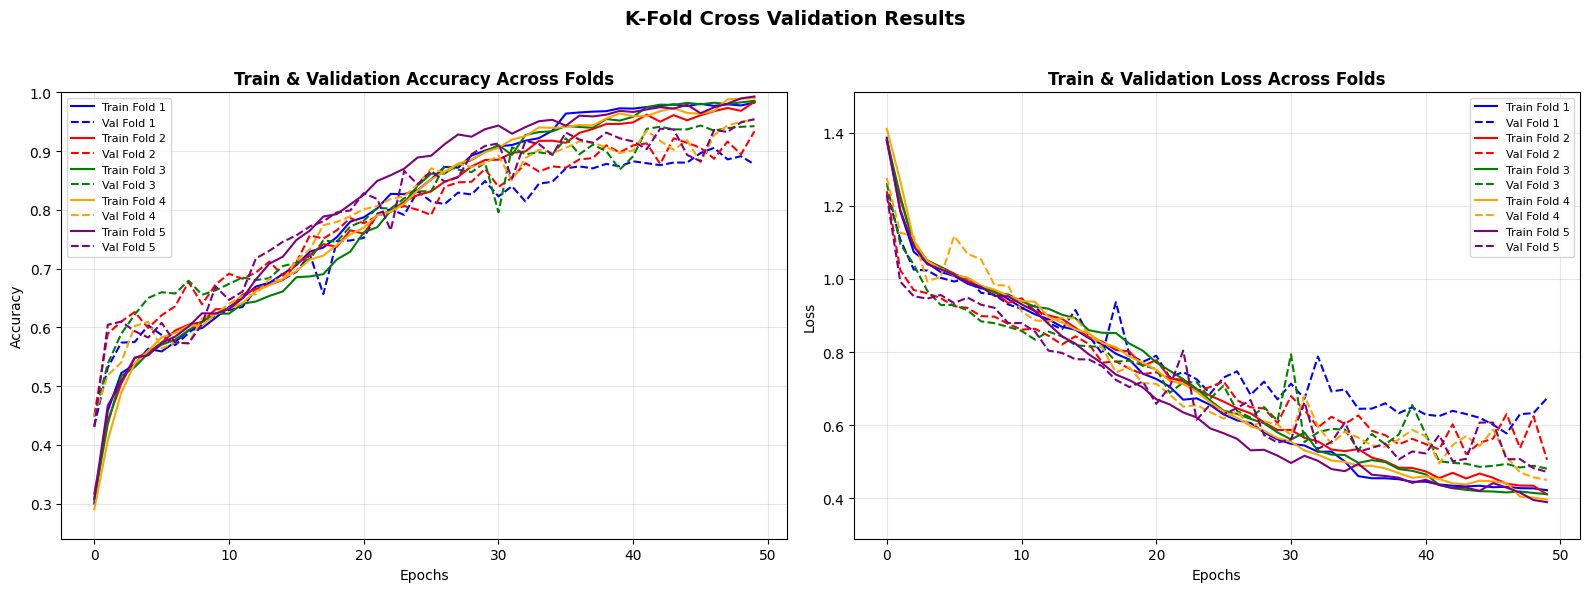


K-Fold Cross-Validation Results Summary
Number of Folds: 5
Mean Final Training Accuracy: 0.9871 ± 0.0039
Mean Final Validation Accuracy: 0.9322 ± 0.0285
Mean Final Training Loss: 0.4061 ± 0.0116
Mean Final Validation Loss: 0.5166 ± 0.0806


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure plots directory exists
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Creating overlaid training metrics from all folds...")

# Check if fold_histories exists
if 'fold_histories' not in locals() or not fold_histories:
    print("⚠ Warning: No fold histories found. Please run K-fold validation first.")
    # Create dummy data to prevent errors
    fold_histories = [{'accuracy': [0.5], 'loss': [1.0], 'val_accuracy': [0.4], 'val_loss': [1.2]}]

n_folds = len(fold_histories)

# Prepare figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('K-Fold Cross Validation Results', fontsize=14, fontweight='bold')

# Define colors for folds (cycle if more than 5 folds)
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Track final metrics
all_final_train_acc = []
all_final_val_acc = []
all_final_train_loss = []
all_final_val_loss = []

# Track min/max values for dynamic y-axis
all_acc_values = []
all_loss_values = []

# Collect data for min/max
for history in fold_histories:
    all_acc_values.extend(history['accuracy'] + history['val_accuracy'])
    all_loss_values.extend(history['loss'] + history['val_loss'])

# Plot fold metrics
for fold_idx, history in enumerate(fold_histories):
    color = colors[fold_idx % len(colors)]
    epochs = range(len(history['accuracy']))

    # Accuracy plot
    axes[0].plot(epochs, history['accuracy'], color=color, linestyle='-', linewidth=1.5, label=f'Train Fold {fold_idx+1}')
    axes[0].plot(epochs, history['val_accuracy'], color=color, linestyle='--', linewidth=1.5, label=f'Val Fold {fold_idx+1}')

    # Loss plot
    axes[1].plot(epochs, history['loss'], color=color, linestyle='-', linewidth=1.5, label=f'Train Fold {fold_idx+1}')
    axes[1].plot(epochs, history['val_loss'], color=color, linestyle='--', linewidth=1.5, label=f'Val Fold {fold_idx+1}')

    # Store final metrics
    all_final_train_acc.append(history['accuracy'][-1])
    all_final_val_acc.append(history['val_accuracy'][-1])
    all_final_train_loss.append(history['loss'][-1])
    all_final_val_loss.append(history['val_loss'][-1])

# Configure Accuracy plot
min_acc = max(0.0, min(all_acc_values) - 0.05)
max_acc = min(1.0, max(all_acc_values) + 0.05)
axes[0].set_title('Train & Validation Accuracy Across Folds', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([min_acc, max_acc])
axes[0].grid(alpha=0.3)
axes[0].legend(fontsize=8)

# Configure Loss plot
min_loss = max(0.0, min(all_loss_values) - 0.1)
max_loss = max(all_loss_values) + 0.1
axes[1].set_title('Train & Validation Loss Across Folds', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_ylim([min_loss, max_loss])
axes[1].grid(alpha=0.3)
axes[1].legend(fontsize=8)

plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig(os.path.join(PLOTS_DIR, 'kfold_validation_results.png'), dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Print Fold Summary Statistics
# -----------------------------
print("\nK-Fold Cross-Validation Results Summary")
print("="*60)
print(f"Number of Folds: {n_folds}")
print(f"Mean Final Training Accuracy: {np.mean(all_final_train_acc):.4f} ± {np.std(all_final_train_acc):.4f}")
print(f"Mean Final Validation Accuracy: {np.mean(all_final_val_acc):.4f} ± {np.std(all_final_val_acc):.4f}")
print(f"Mean Final Training Loss: {np.mean(all_final_train_loss):.4f} ± {np.std(all_final_train_loss):.4f}")
print(f"Mean Final Validation Loss: {np.mean(all_final_val_loss):.4f} ± {np.std(all_final_val_loss):.4f}")
print("="*60)


2025-09-13 11:34:33.286146: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-13 11:34:40.159496: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

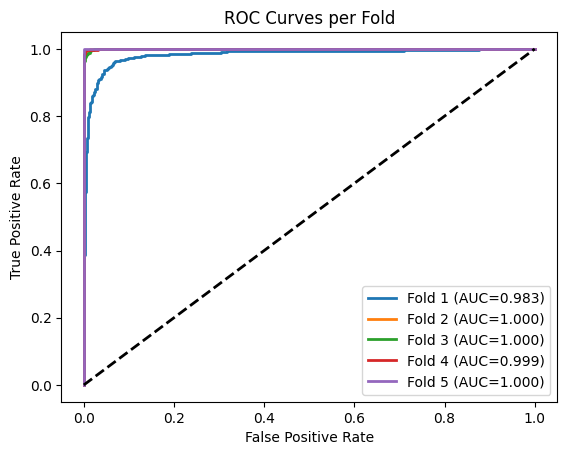

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

all_fpr = []
all_tpr = []
all_roc_auc = []

for fold_idx, model in enumerate(fold_models):
    X_val, y_val = preprocess_images(
        all_file_paths[skfold.split(all_file_paths, all_labels_encoded).__iter__().__next__()[1]],
        all_labels_encoded[skfold.split(all_file_paths, all_labels_encoded).__iter__().__next__()[1]],
        KFOLD_CONFIG['image_size'],
        n_classes
    )
    
    y_true = np.argmax(y_val, axis=1)             # one-hot → class indices
    y_true_onehot = y_val                         # already one-hot
    y_score = model.predict(X_val, verbose=0)     # PROBABILITIES ✅
    
    fpr, tpr, _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f"Fold {fold_idx+1} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Fold")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

num_classes = len(class_names)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple'])
class_colors = ['red', 'green', 'blue', 'orange', 'purple']

actual_num_folds = len(fold_predictions)
fig, axes = plt.subplots(1, actual_num_folds, figsize=(6*actual_num_folds, 6))
if actual_num_folds == 1:
    axes = [axes]

for fold_idx in range(actual_num_folds):
    ax = axes[fold_idx] if actual_num_folds > 1 else axes[0]
    y_score = fold_predictions[fold_idx]          # probabilities
    y_true = fold_true_labels[fold_idx]           # class indices
    y_true_onehot = np.eye(num_classes)[y_true]   # convert to one-hot

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=class_colors[i], lw=2, label=f'{class_names[i]} (AUC={roc_auc:.3f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx+1} ROC')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Advanced Model Interpretability

The following sections implement SHAP, LIME visualizations for our lightweight ViT model.



Processing class: Gerd
Number of correctly classified images for Gerd: 2

Generating SHAP explanation for image index 0 (Class: Gerd)
True Class: Gerd
Model Prediction Probabilities:
 - Gerd: 0.9525
 - Gerd Normal: 0.0143
 - Polyp: 0.0161
 - Polyp Normal: 0.0170
Predicted Class: Gerd (Probability: 0.9525)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.17s/it]               


<Figure size 1000x800 with 0 Axes>

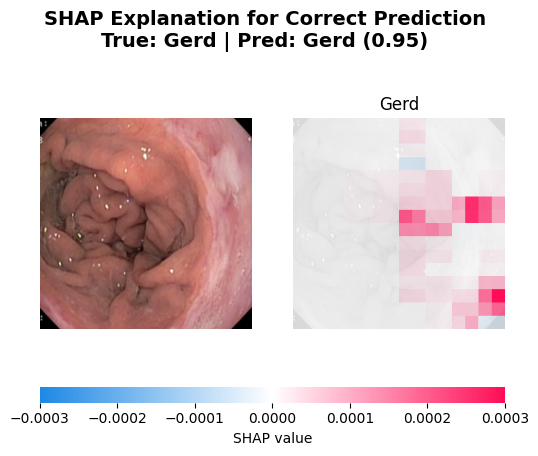


Generating SHAP explanation for image index 1 (Class: Gerd)
True Class: Gerd
Model Prediction Probabilities:
 - Gerd: 0.9379
 - Gerd Normal: 0.0234
 - Polyp: 0.0164
 - Polyp Normal: 0.0222
Predicted Class: Gerd (Probability: 0.9379)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.73s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

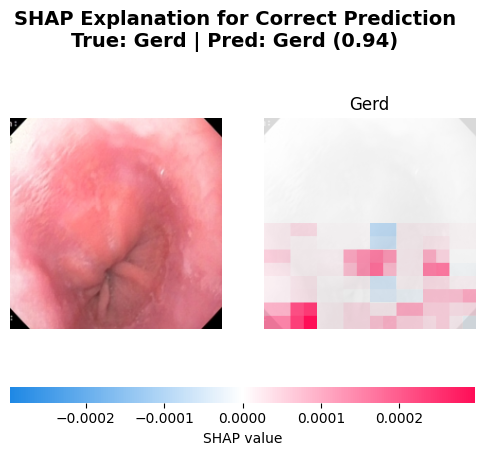


Generating combined SHAP explanation for all classes on image index 0 (Class: Gerd)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.67s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

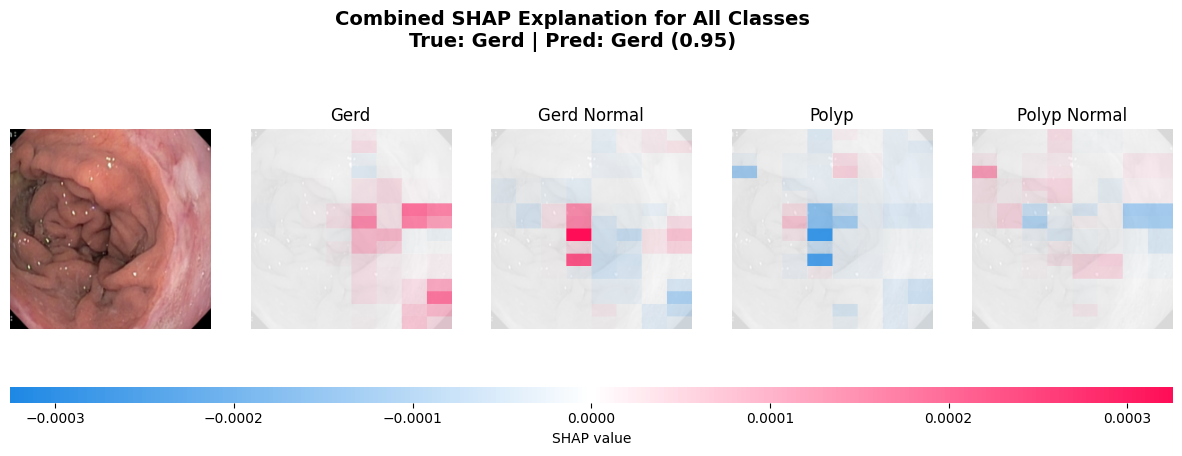


Processing class: Gerd Normal
Number of correctly classified images for Gerd Normal: 2

Generating SHAP explanation for image index 2 (Class: Gerd Normal)
True Class: Gerd Normal
Model Prediction Probabilities:
 - Gerd: 0.0153
 - Gerd Normal: 0.9525
 - Polyp: 0.0157
 - Polyp Normal: 0.0165
Predicted Class: Gerd Normal (Probability: 0.9525)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.37s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

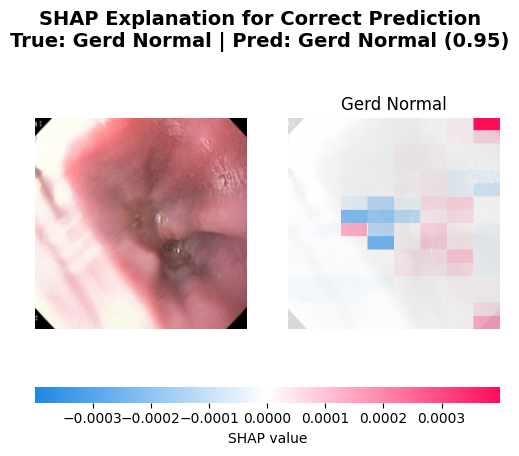


Generating SHAP explanation for image index 3 (Class: Gerd Normal)
True Class: Gerd Normal
Model Prediction Probabilities:
 - Gerd: 0.0170
 - Gerd Normal: 0.9478
 - Polyp: 0.0198
 - Polyp Normal: 0.0154
Predicted Class: Gerd Normal (Probability: 0.9478)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.63s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

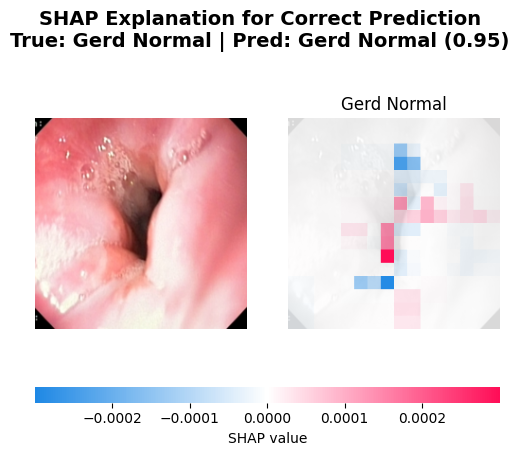


Generating combined SHAP explanation for all classes on image index 2 (Class: Gerd Normal)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.28s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

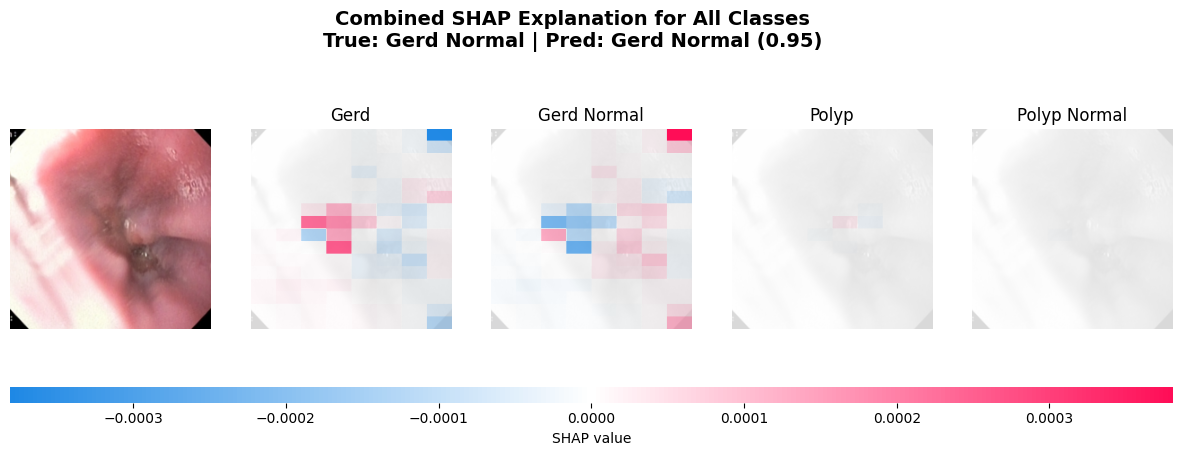


Processing class: Polyp
Number of correctly classified images for Polyp: 2

Generating SHAP explanation for image index 4 (Class: Polyp)
True Class: Polyp
Model Prediction Probabilities:
 - Gerd: 0.0176
 - Gerd Normal: 0.0189
 - Polyp: 0.9460
 - Polyp Normal: 0.0175
Predicted Class: Polyp (Probability: 0.9460)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.18s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

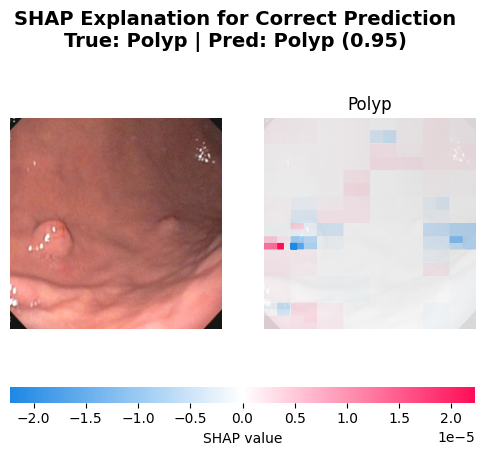


Generating SHAP explanation for image index 5 (Class: Polyp)
True Class: Polyp
Model Prediction Probabilities:
 - Gerd: 0.0178
 - Gerd Normal: 0.0187
 - Polyp: 0.9470
 - Polyp Normal: 0.0164
Predicted Class: Polyp (Probability: 0.9470)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.90s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

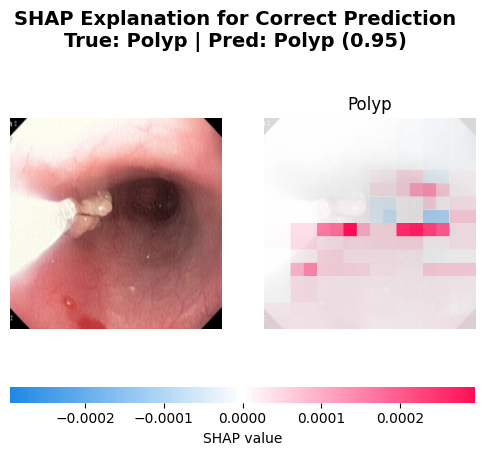


Generating combined SHAP explanation for all classes on image index 4 (Class: Polyp)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.98s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

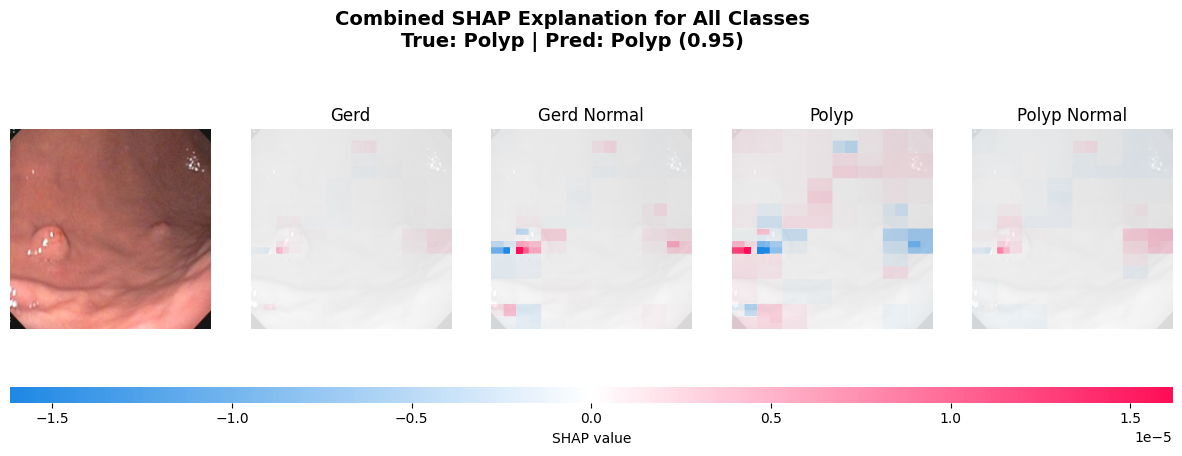


Processing class: Polyp Normal
Number of correctly classified images for Polyp Normal: 2

Generating SHAP explanation for image index 6 (Class: Polyp Normal)
True Class: Polyp Normal
Model Prediction Probabilities:
 - Gerd: 0.0199
 - Gerd Normal: 0.0191
 - Polyp: 0.0125
 - Polyp Normal: 0.9485
Predicted Class: Polyp Normal (Probability: 0.9485)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.05s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

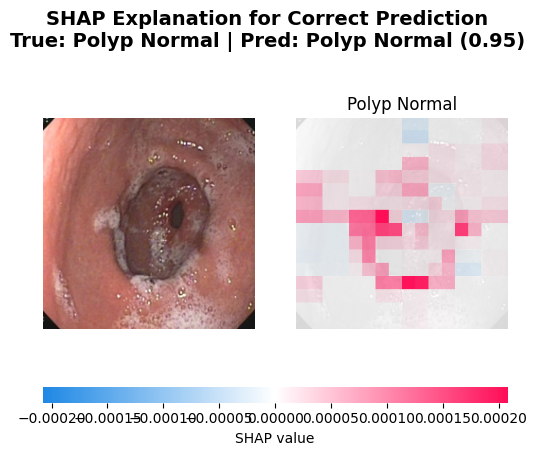


Generating SHAP explanation for image index 7 (Class: Polyp Normal)
True Class: Polyp Normal
Model Prediction Probabilities:
 - Gerd: 0.0224
 - Gerd Normal: 0.0239
 - Polyp: 0.0116
 - Polyp Normal: 0.9421
Predicted Class: Polyp Normal (Probability: 0.9421)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.07s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

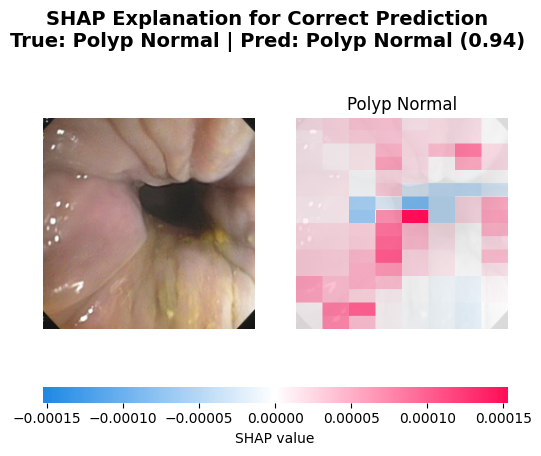


Generating combined SHAP explanation for all classes on image index 6 (Class: Polyp Normal)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.96s/it]               


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

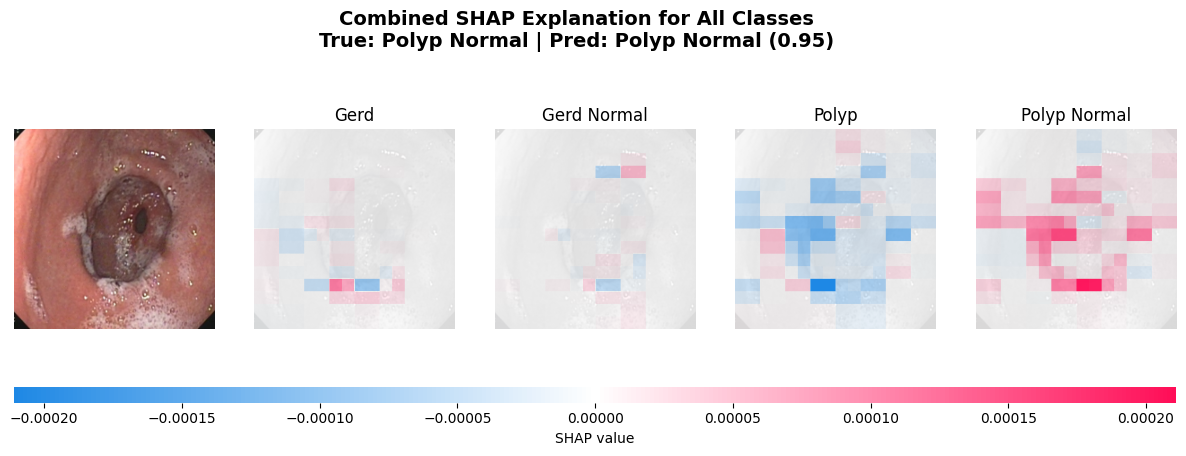

SHAP analysis completed for all classes.


<Figure size 640x480 with 0 Axes>

In [24]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob

def load_images_from_folder(root_folder, image_size=(224, 224), max_images_per_class=2):
    """
    Load images from subfolders named after classes in the root folder.
    Returns images, labels, and class names.
    """
    class_names = sorted([d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))])
    images = []
    labels = []
    class_indices = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(root_folder, class_name)
        image_paths = glob.glob(os.path.join(class_path, '*.jpg')) + glob.glob(os.path.join(class_path, '*.png'))
        
        # Limit to max_images_per_class per class
        selected_paths = image_paths[:max_images_per_class]
        
        for img_path in selected_paths:
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                images.append(np.array(img))
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                
    images = np.array(images, dtype=np.uint8)
    labels = np.array(labels, dtype=np.int32)
    
    # Convert labels to one-hot encoding
    labels_one_hot = np.zeros((len(labels), len(class_names)))
    for i, label in enumerate(labels):
        labels_one_hot[i, label] = 1
        
    return images, labels_one_hot, class_names

def generate_shap_explanations(model, root_folder, image_size=(224, 224)):
    """
    Generate SHAP explanations for two images per class from the root folder.
    """
    # Load images and labels
    test_images_unnormalized, test_labels, class_names = load_images_from_folder(root_folder, image_size)
    
    if len(test_images_unnormalized) == 0:
        print("No images found in the specified folder.")
        return
    
    def model_predict(x):
        # Normalize to [0, 1] before prediction
        preds = model(tf.convert_to_tensor(x / 255.0))
        return preds.numpy()

    # SHAP masker for images
    masker = shap.maskers.Image("inpaint_telea", test_images_unnormalized[0].shape)

    # SHAP explainer
    explainer = shap.Explainer(model_predict, masker, output_names=class_names)

    # Step 1: Group images by class
    class_to_indices = {i: [] for i in range(len(class_names))}
    for idx, label in enumerate(np.argmax(test_labels, axis=1)):
        class_to_indices[label].append(idx)

    # Step 2: Generate SHAP explanations for up to 2 correctly classified images per class
    for class_idx, indices in class_to_indices.items():
        class_name = class_names[class_idx]
        print(f"\nProcessing class: {class_name}")
        
        # Filter for correctly classified images
        correct_indices = []
        for idx in indices:
            image = test_images_unnormalized[idx]
            prediction = model_predict(image[np.newaxis, ...])[0]
            predicted_class = np.argmax(prediction)
            true_class_idx = np.argmax(test_labels[idx])
            if predicted_class == true_class_idx:
                correct_indices.append(idx)
        
        # Limit to 2 images
        correct_indices = correct_indices[:2]
        print(f"Number of correctly classified images for {class_name}: {len(correct_indices)}")
        
        for idx in correct_indices:
            image = test_images_unnormalized[idx]
            true_class_idx = np.argmax(test_labels[idx])
            true_class_name = class_names[true_class_idx]

            prediction = model_predict(image[np.newaxis, ...])[0]
            predicted_class = np.argmax(prediction)
            predicted_prob = prediction[predicted_class]

            print(f"\nGenerating SHAP explanation for image index {idx} (Class: {class_name})")
            print(f"True Class: {true_class_name}")
            print("Model Prediction Probabilities:")
            for i, prob in enumerate(prediction):
                print(f" - {class_names[i]}: {prob:.4f}")
            print(f"Predicted Class: {class_names[predicted_class]} (Probability: {predicted_prob:.4f})")

            # SHAP explanation for the predicted class
            shap_values = explainer(image[np.newaxis, ...], outputs=shap.Explanation.argsort.flip[:1])

            plt.figure(figsize=(10, 8))
            shap.image_plot(shap_values, image[np.newaxis, ...], show=False)

            plt.suptitle(
                f"SHAP Explanation for Correct Prediction\nTrue: {true_class_name} | Pred: {class_names[predicted_class]} ({predicted_prob:.2f})",
                fontsize=14,
                fontweight='bold'
            )
            plt.show()
            plt.clf()

        # Step 3: Generate one combined SHAP image for all classes on the first correctly classified image (if any)
        if len(correct_indices) > 0:
            idx = correct_indices[0]
            image = test_images_unnormalized[idx]
            print(f"\nGenerating combined SHAP explanation for all classes on image index {idx} (Class: {class_name})")

            # Get SHAP values for all classes
            shap_values_all = explainer(image[np.newaxis, ...])

            plt.figure(figsize=(12, 10))
            shap.image_plot(shap_values_all, image[np.newaxis, ...], show=False)

            true_class_idx = np.argmax(test_labels[idx])
            true_class_name = class_names[true_class_idx]
            prediction = model_predict(image[np.newaxis, ...])[0]
            predicted_class = np.argmax(prediction)
            predicted_prob = prediction[predicted_class]

            plt.suptitle(
                f"Combined SHAP Explanation for All Classes\nTrue: {true_class_name} | Pred: {class_names[predicted_class]} ({predicted_prob:.2f})",
                fontsize=14,
                fontweight='bold'
            )
            plt.show()
            plt.clf()
        else:
            print(f"No correctly classified images found for class {class_name} to generate combined SHAP visualization.")

    print("SHAP analysis completed for all classes.")

# Example usage:
root_folder = "/kaggle/input/auggerd/Gerd_Aug"
generate_shap_explanations(model, root_folder)

Detected classes: ['Gerd', 'Gerd Normal', 'Polyp', 'Polyp Normal']

Analyzing image 1:
Image path: /kaggle/input/auggerd/Gerd_Aug/Gerd/augmented_pil_0_b1.03_c1.01_col1.06.jpg
True label: Gerd


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

2025-09-13 11:44:43.006681: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted: Gerd (0.957)


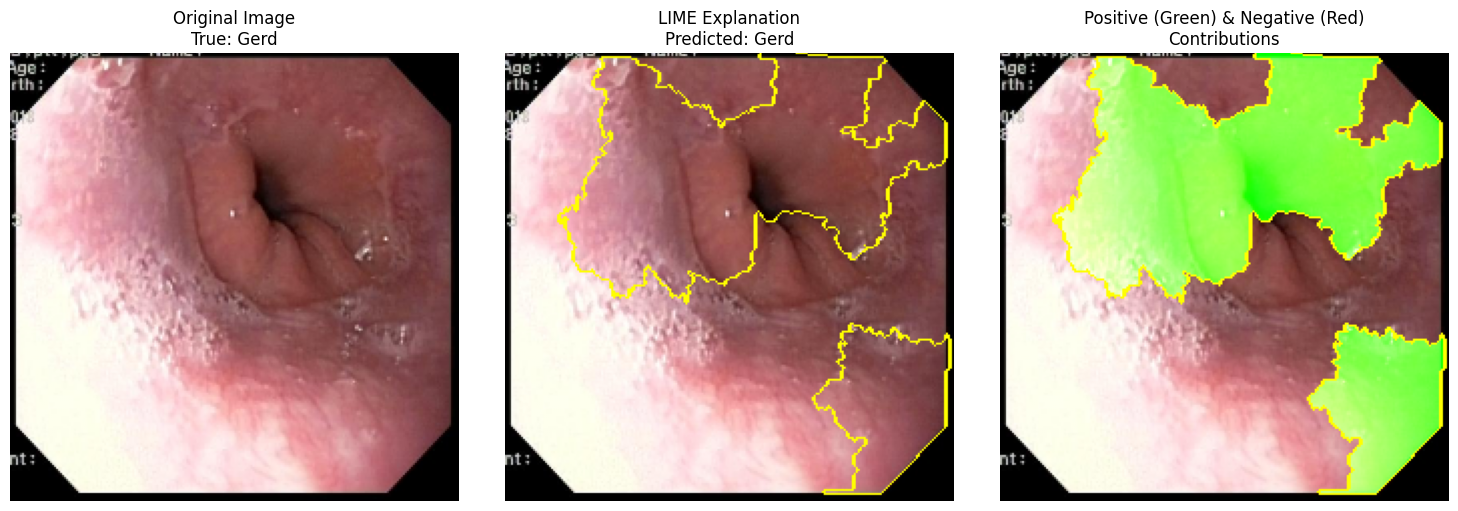

Prediction probabilities:
  Gerd: 0.9565
  Gerd Normal: 0.0138
  Polyp: 0.0139
  Polyp Normal: 0.0158

Analyzing image 2:
Image path: /kaggle/input/auggerd/Gerd_Aug/Gerd/augmented_pil_1008_b0.87_c0.76_col0.76.jpg
True label: Gerd


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-09-13 11:44:52.562099: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted: Gerd (0.950)


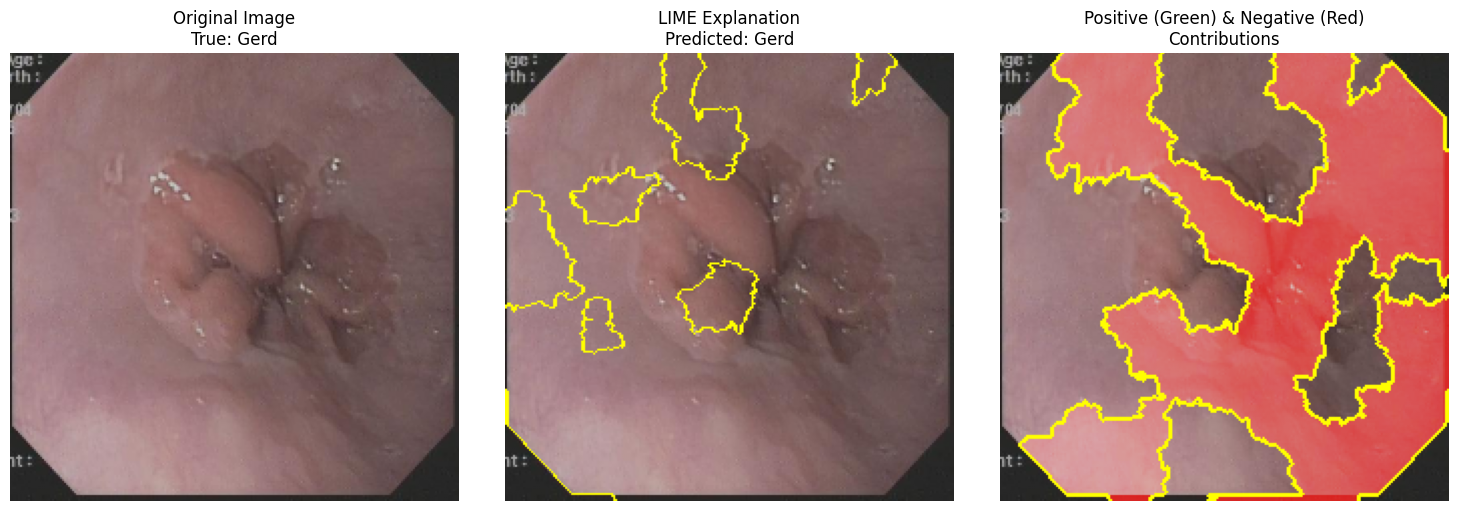

Prediction probabilities:
  Gerd: 0.9503
  Gerd Normal: 0.0198
  Polyp: 0.0142
  Polyp Normal: 0.0157

Analyzing image 3:
Image path: /kaggle/input/auggerd/Gerd_Aug/Gerd Normal/augmented_pil_0_b0.87_c1.19_col0.90.jpg
True label: Gerd Normal


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-09-13 11:45:02.227146: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted: Gerd Normal (0.938)


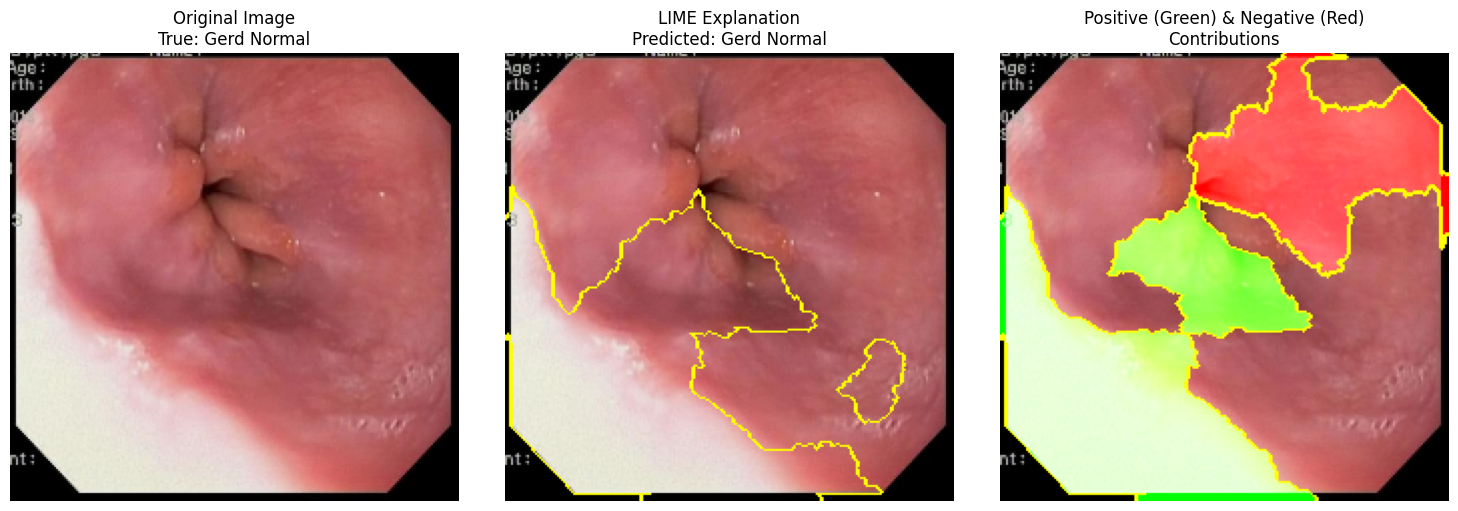

Prediction probabilities:
  Gerd: 0.0187
  Gerd Normal: 0.9375
  Polyp: 0.0221
  Polyp Normal: 0.0217

Analyzing image 4:
Image path: /kaggle/input/auggerd/Gerd_Aug/Gerd Normal/augmented_pil_1008_b1.28_c0.79_col1.09.jpg
True label: Gerd Normal


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-09-13 11:45:11.915009: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted: Gerd Normal (0.953)


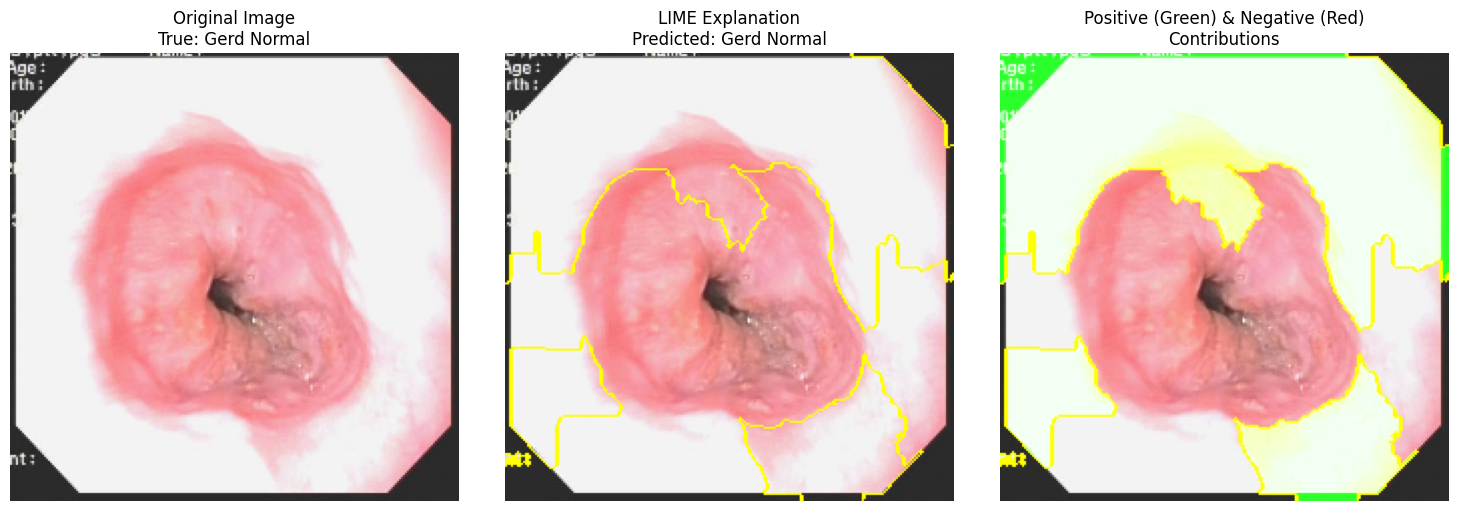

Prediction probabilities:
  Gerd: 0.0136
  Gerd Normal: 0.9532
  Polyp: 0.0163
  Polyp Normal: 0.0169

Analyzing image 5:
Image path: /kaggle/input/auggerd/Gerd_Aug/Polyp/augmented_pil_0_b1.22_c1.25_col1.02.jpg
True label: Polyp


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-09-13 11:45:21.484171: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted: Polyp (0.907)


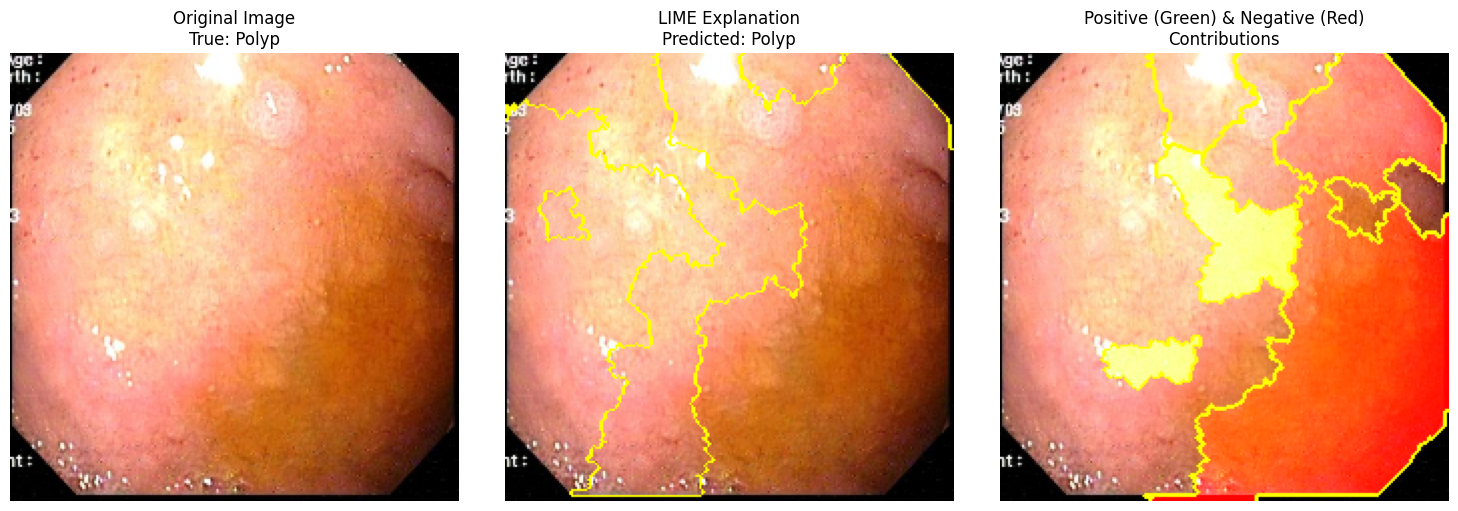

Prediction probabilities:
  Gerd: 0.0413
  Gerd Normal: 0.0245
  Polyp: 0.9068
  Polyp Normal: 0.0275

Analyzing image 6:
Image path: /kaggle/input/auggerd/Gerd_Aug/Polyp/augmented_pil_1008_b1.25_c1.22_col1.15.jpg
True label: Polyp


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/st

2025-09-13 11:45:30.706463: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted: Polyp (0.955)


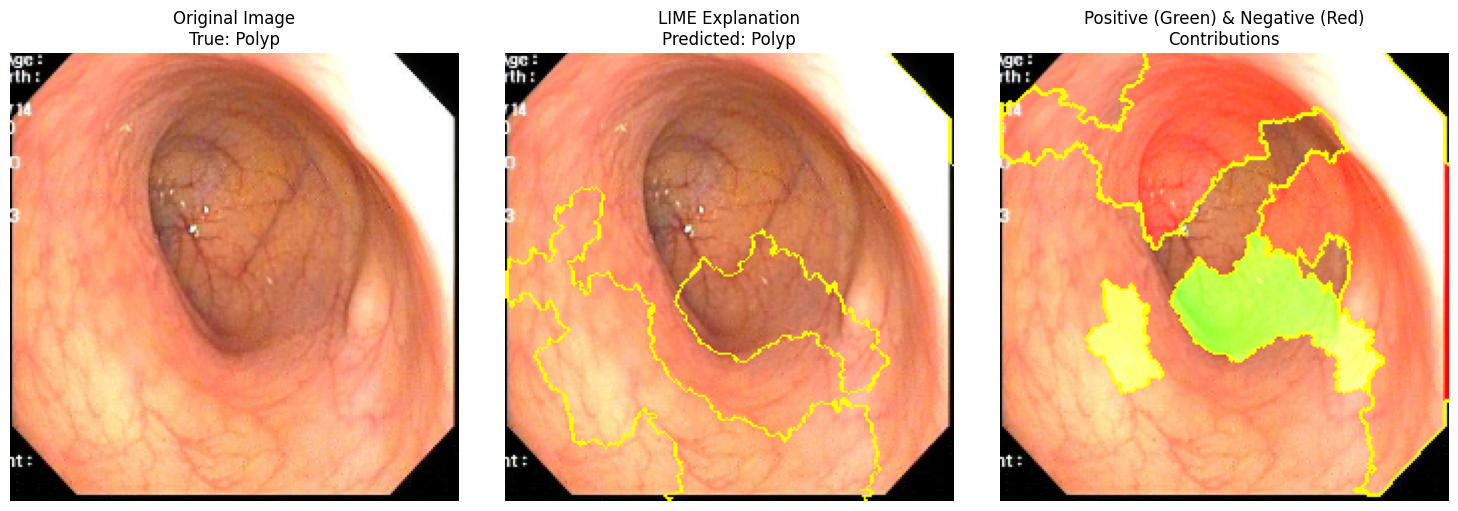

Prediction probabilities:
  Gerd: 0.0174
  Gerd Normal: 0.0159
  Polyp: 0.9546
  Polyp Normal: 0.0121

Analyzing image 7:
Image path: /kaggle/input/auggerd/Gerd_Aug/Polyp Normal/augmented_pil_0_b0.90_c0.97_col1.05.jpg
True label: Polyp Normal


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-09-13 11:45:40.382655: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted: Polyp Normal (0.946)


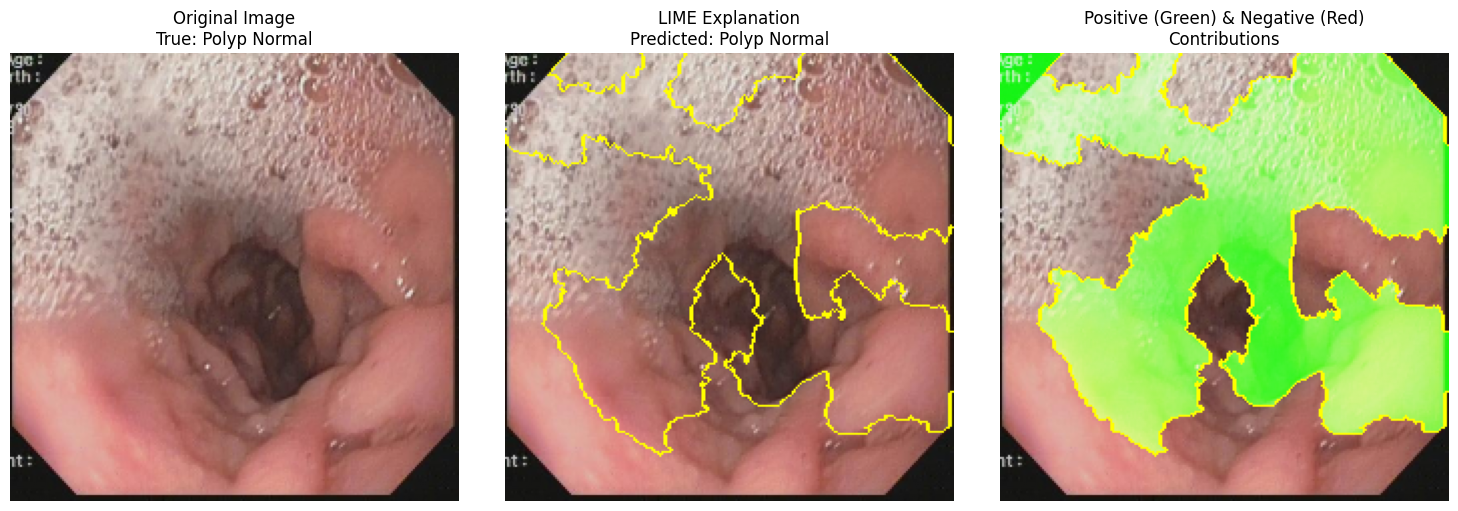

Prediction probabilities:
  Gerd: 0.0213
  Gerd Normal: 0.0213
  Polyp: 0.0114
  Polyp Normal: 0.9460

Analyzing image 8:
Image path: /kaggle/input/auggerd/Gerd_Aug/Polyp Normal/augmented_pil_1008_b1.20_c0.87_col0.75.jpg
True label: Polyp Normal


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-09-13 11:45:52.215986: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted: Polyp Normal (0.946)


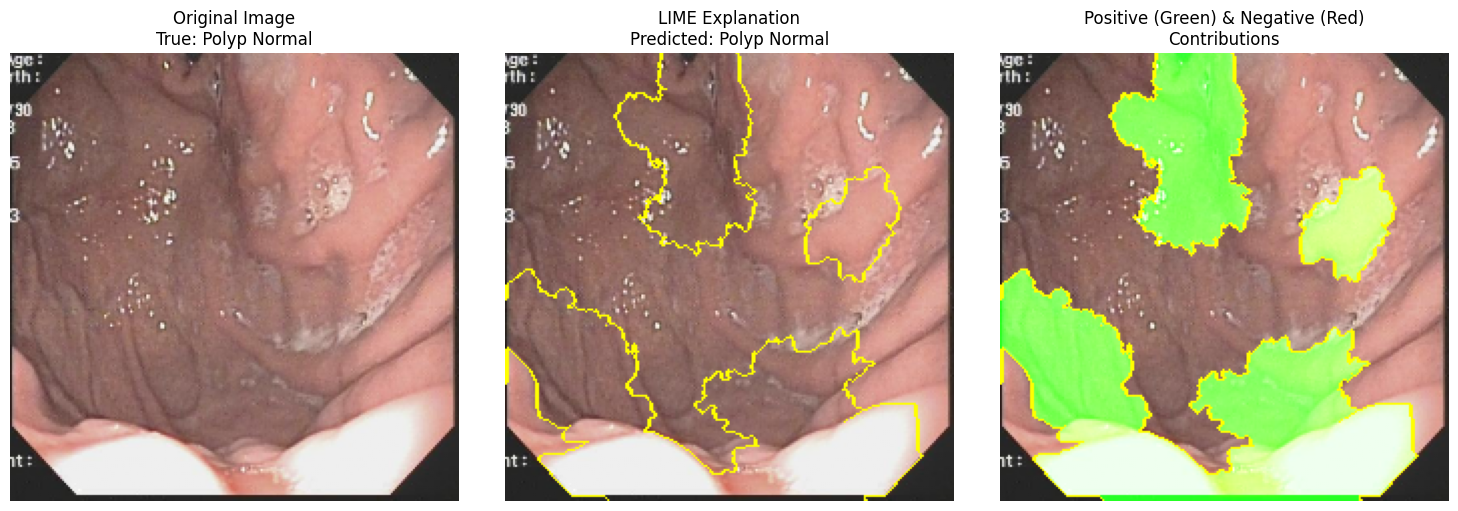

Prediction probabilities:
  Gerd: 0.0163
  Gerd Normal: 0.0140
  Polyp: 0.0238
  Polyp Normal: 0.9459


In [25]:
import lime
from lime import lime_image
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import os
from skimage.segmentation import mark_boundaries

# -------------------- Image Preprocessing --------------------
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0,1]
    return img

# -------------------- Load Model --------------------
model = model  # or load_model('/kaggle/input/your-model/model.h5')

# -------------------- Dynamic Class Names --------------------
dataset_dir = '/kaggle/input/auggerd/Gerd_Aug'
class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
print("Detected classes:", class_names)

# -------------------- Load Test Images --------------------
test_images = []
image_paths = []
true_labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    img_files = sorted([f for f in os.listdir(class_dir)
                        if f.endswith(('.jpeg', '.jpg', '.png'))])[:2]  # Take first 2 images
    for img_file in img_files:
        img_path = os.path.join(class_dir, img_file)
        image_paths.append(img_path)
        test_images.append(preprocess_image(img_path))
        true_labels.append(class_name)

X = np.array(test_images)

# -------------------- Define LIME Explainer --------------------
explainer = lime_image.LimeImageExplainer()

# -------------------- Explain and Plot --------------------
for i in range(len(X)):
    print(f"\nAnalyzing image {i+1}:")
    print(f"Image path: {image_paths[i]}")
    print(f"True label: {true_labels[i]}")
    
    # Get explanation
    explanation = explainer.explain_instance(
        X[i], 
        model.predict, 
        top_labels=3, 
        hide_color=0, 
        num_samples=1000,
        batch_size=32
    )
    
    # Get predicted class and probability
    prediction = model.predict(X[i].reshape(1, 224, 224, 3))
    predicted_class = class_names[np.argmax(prediction)]
    predicted_prob = np.max(prediction)
    
    print(f"Predicted: {predicted_class} ({predicted_prob:.3f})")
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axes[0].imshow(X[i])
    axes[0].set_title(f'Original Image\nTrue: {true_labels[i]}')
    axes[0].axis('off')
    
    # Plot explanation for top predicted class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    axes[1].imshow(mark_boundaries(temp, mask))
    axes[1].set_title(f'LIME Explanation\nPredicted: {predicted_class}')
    axes[1].axis('off')
    
    # Plot explanation with positive and negative contributions
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=False
    )
    axes[2].imshow(mark_boundaries(temp, mask))
    axes[2].set_title('Positive (Green) & Negative (Red)\nContributions')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed prediction probabilities
    print("Prediction probabilities:")
    for j, class_name in enumerate(class_names):
        print(f"  {class_name}: {prediction[0][j]:.4f}")
